## INT IDS Long-slit Spectroscopy Reduction

This pipeline performs all the basic CCD data reduction. The steps are as follows:
- create a master bias frame
- create a master lamp flat frame
- create a master sky flat frame

- reduce individual science frames. Perform gain correction, bias subtraction, flat fielding and sky subtraction
- median combine reduced science frames into a deep spectrum

- reduce arc frames for wavelength calibration

- wavelength calibrate the 2D science spectrum
- extract and save 1D spectrum from a given position and aperture size. This feature requires the python package mpdaf. This can be downloaded using `pip install mpdaf` for python2 or `pip3 install mpdaf` for python3.

To add: flux calibration

The following reduction code works directly from the full set of images in a given night's observations. As observations are added during the evening, the ImageFileCollection object defined at the beginning needs to be refreshed.

ftp where frames are stored: rsync -av intobs@intdrpc1:/obsdata/inta/20190405/ .

password: int_guest

In [1]:
### Import all relevant packages.
import warnings
import numpy as np

from multiprocessing import Pool
from functools import partial
import os

import astropy.units as u
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.stats import sigma_clip, mad_std
from astropy.convolution import convolve, Gaussian2DKernel

from scipy.ndimage import binary_dilation
from astropy.utils.console import ProgressBar

import ccdproc
from ccdproc import ImageFileCollection, CCDData
from astropy.stats import sigma_clipped_stats
import scipy.optimize as optimize

import glob

import scipy
import matplotlib.pyplot as plt

from mpdaf.obj import Spectrum, WaveCoord

In [2]:
### Define functions relevant for calibration

def fit_chebyshev(row, degree=7, grow=3):
    """
    Fit Chebyshev1D model to a CCD row, including masking of outlier pixels
    
    Params
    ------
    row : array,
        Input CCD row to fit polynomial to.
    degree : int,
        Chebyshev Polynomial Order
    grow : int,
        Number of iterations to dilate around masked pixels
    """

    fitter = fitting.LinearLSQFitter()
    input_mask = row.mask
    clipped = sigma_clip(row, stdfunc=mad_std)
    clipped_pixels = np.array(clipped.mask+row.mask).astype('float')
    clipped_pixels = binary_dilation(clipped_pixels, iterations=grow)

    row[clipped_pixels==1] = np.median(row)
    masked_row = np.ma.array(data=row, 
                             mask=(clipped_pixels == 1), 
                             fill_value=np.median(row))
    x = np.arange(len(row))
    model = models.Chebyshev1D(degree=degree)
    fitted_model = fitter(model, x, row)
    return fitted_model(np.arange(len(row)))


def fit_background(data, degree=7, grow=3, verbose=True, njobs=2):
    """
    Parallelised background estimation for longslit CCD image
    
    Params
    ------
    data : array,
        Input CCD data for background estimation.
    degree : int,
        Chebyshev Polynomial Order
    grow : int,
        Number of iterations to dilate around masked pixels
    njobs : int
        Number of processes to initiate for fitting
    """
    kwargs={'degree': degree, 'grow': grow}    
    p = Pool(njobs)
    fitted_sky = p.map(partial(fit_chebyshev, **kwargs), data)
    p.close()
    return np.array(fitted_sky).astype('float')


### Edit the primary HDU and save

def edit_header(filename):
    hdulist = fits.open(filename)
    hdr = hdulist[0].header
    
    try:
        hdulist[0]
        hdulist.writeto(filename, overwrite=True)
    except KeyError:
        print("Keyword not found!")
        
        
### Dispersion functions wavelength calibration
def wavesol(x, m, c):
    return m*x + c

def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))
    

In [3]:
### Select observing night, the working directory and create the relevant folders

obs_night = "20190523"

### Directory with all the raw files from an observing night
workdir = "/Users/aayushsaxena/Desktop/phd/HzQ_2019/Data/INT_2019B/%s/" %obs_night

os.chdir(workdir)

try:
    os.mkdir("./processed_new/")
except OSError:
    pass


In [4]:
### Load in all the files from the observing night

### For non-standard keyword in the header, run the edit_header function below. 
### If no error is flagged by ic1 then this function is not required

# filenames = glob.glob("*.fit")
# for file in filenames:
#     edit_header(file)


ic1 = ImageFileCollection(workdir)
ic1.summary

file,simple,bitpix,naxis,extend,run,irafname,runset,sysver,origin,observat,observer,proposal,object,obstype,imagetyp,latitude,longitud,height,slatel,telescop,telstat,ra,dec,equinox,radecsys,utobs,xapnom,yapnom,xapoff,yapoff,raoff,decoff,mjd-obs,jd,ststart,st,azstart,azend,zdstart,zdend,fstation,platesca,telfocus,actelfoc,rottrack,rotskypa,mntpasta,mntpaend,paransta,paranend,vignette,dazstart,dazend,airmass,amstart,amend,temptube,focustmp,focusalt,focusflt,autox,autoy,automode,cat-name,cat-ra,cat-dec,cat-equi,cat-epoc,pm-ra,pm-dec,parallax,radvel,ratrack,dectrack,agtvposx,agtvposy,agtvfilt,agtvshut,agposx,agposy,asndfilt,ascfilt,agarclmp,compmpos,autofilt,agcfilna,agcfilnb,instrume,camera,slitwid,pslitwid,sltwdsky,dekkerid,dekpos,bscfilt,bsndfilt,collname,collfoc,hartmanr,hartmanl,gratname,glinesmm,gratblaz,gratangl,gratshut,cenwave,detector,ccdspeed,ccdxbin,ccdybin,ccdsum,ccdtemp,ccdtemp1,ccdtemp2,nwindows,winsec1,winsec2,winsec3,winsec4,readmode,stormode,numreads,coaverag,date-obs,ut,utstart,ut-mid,exposed,exptime,elapsed,darktime,reqtime,dispaxis,comment
str12,bool,int64,int64,bool,int64,str8,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,str8,str4,int64,int64,str3,float64,float64,float64,int64,str26,str19,str19,str19,str6,str6,int64,int64,str10,str12,str12,str12,float64,float64,float64,float64,float64,int64,object
r1457963.fit,True,8,0,True,1457963,r1457963,1:1:1457963,S1-27,ING La Palma,LAPALMA,Julia de Leon,C94,rotation test,ARC,arc,28.761932,-17.87758,2348,LPO2.5,INT,ENGMODE,0:00:00.000,+00:00:00.00,2000.0,FK5,13:04:46.1,0.0,0.0,0.0,0.0,0.0,0.0,58626.5449779,2458627.0449779,3:56:40.6,3:56:40.6,359.927419,359.927419,0.045951,0.045944,CASSEGRAIN,1.502645,0.015287,0.015818,True,-0.001782,-0.001782,-0.001782,62.999834,63.001399,False,158.515809,158.515809,1.0,1.0,1.0,12.477739,0.531025,0.0,0.0,0.0,0.0,UNLOCKED,441,20:56:46.100,-10:35:53.00,J2000.00,2000.0,0.0,0.0,0.0,0.0,0.003,0.003,0.497773,0.500004,F0 Clear,OPEN,0.410278,0.472475,F0 Clear,F0 Clear,CuAr CuAr CuNe CuN,IN,F0 Clear,F0 Clear,F0 Clear,IDS,235,0.00028,0.047,1.515,D-CORO,P0 Clear,F0 Clear,F0 empty,Al-wide,226,OPEN,OPEN,R400R,400,7250.0,62.9,OPEN,7505.571,REDPLUS2,FAST,1,1,1 1,156.887,0.0,0.0,1,"[800:1165,1:4200], enabled","[0:0,0:0], disabled","[0:0,0:0], disabled","[0:0,0:0], disabled",simple,normal,1,1,2019-05-23,13:04:46.470,13:04:46.470,13:04:51.475,10.01,10.01,10.2619289,10.2619289,10.0,2,--
r1457964.fit,True,8,0,True,1457964,r1457964,1:1:1457964,S1-27,ING La Palma,LAPALMA,Julia de Leon,C94,rotation test,ARC,arc,28.761932,-17.87758,2348,LPO2.5,INT,ENGMODE,0:00:00.000,+00:00:00.00,2000.0,FK5,13:10:13.1,0.0,0.0,0.0,0.0,0.0,0.0,58626.5487626,2458627.0487626,4:02:08.4,4:02:08.4,359.927419,359.927419,0.045951,0.045951,CASSEGRAIN,1.502645,0.015287,0.015818,True,-0.001782,-0.001782,-0.001782,63.044094,63.045228,False,158.515809,158.515809,1.0,1.0,1.0,12.506934,0.531025,0.0,0.0,0.0,0.0,UNLOCKED,441,20:56:46.100,-10:35:53.00,J2000.00,2000.0,0.0,0.0,0.0,0.0,0.003,0.003,0.497773,0.500004,F0 Clear,OPEN,0.410278,0.472475,F0 Clear,F0 Clear,CuAr CuAr CuNe CuN,IN,F0 Clear,F0 Clear,F0 Clear,IDS,235,0.00028,0.047,1.515,D-CORO,P0 Clear,F0 Clear,F0 empty,Al-wide,226,OPEN,OPEN,R400R,400,7250.0,62.9,OPEN,7505.571,REDPLUS2,FAST,1,1,1 1,156.103,0.0,0.0,1,"[800:1165,1:4200], enabled","[0:0,0:0], disabled","[0:0,0:0], disabled","[0:0,0:0], disa

In [5]:
print(ic1.files_filtered(obstype='TARGET', object="J160+54"))

['r1458049.fit' 'r1458050.fit' 'r1458051.fit']


## Create/read biases

In [6]:
### Run this the first time to create master bias frames

try:
    os.mkdir("./processed_new/BIAS/")
except OSError:
    pass

### Create red master bias
red_bias_list = []

for filename in ic1.files_filtered(obstype='BIAS', object='Bias'):
    ccd = CCDData.read(ic1.location + filename, unit = u.electron)
    ccd = ccdproc.subtract_overscan(ccd, median=True,  overscan_axis=0, overscan=ccd[4110:4190,:])
    ccd = ccdproc.trim_image(ccd[:,:4096])

    #this has to be fixed as the bias section does not include the whole section that will be trimmed
    red_bias_list.append(ccd)

master_bias = ccdproc.combine(red_bias_list, method='median')
master_bias.write('./processed_new/BIAS/master_bias.fits', overwrite=True)

### uncomment the following line once master bias created to simply load in the relevant bias
# master_bias = CCDData.read('./processed/BIAS/master_bias.fits', unit=u.adu)

print("Master Bias created")

INFO:astropy:first HDU with data is extension 1.
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma.
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Changed DATE-OBS from '2019-05-23        ' to '2019-05-23T00:00:00.0''. [astropy.wcs.wcs]
Changed DATE-OBS from '2019-05-23        ' to '2019-05-23T00:00:00.0''.
INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]


INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]


INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]


INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
Master Bias created


## Create/read flats

### Lamp flats
These are taken as part of the afternoon calibrations with complamps W

In [7]:
### Lamp flats

try:
    os.mkdir("processed_new/FLAT/")
except OSError:
    pass

red_flat_list = []
for filename in ic1.files_filtered(obstype='FLAT'):
    ccd = CCDData.read(ic1.location + filename, unit = u.electron)

    #this has to be fixed as the bias section does not include the whole section that will be trimmed
    ccd = ccdproc.subtract_overscan(ccd, median=True,  overscan_axis=0, overscan=ccd[4110:4190,:])
    ccd = ccdproc.trim_image(ccd[:,:4096])
    ccd = ccdproc.subtract_bias(ccd, master_bias)    
    red_flat_list.append(ccd)

master_flat = ccdproc.combine(red_flat_list, method='median')
# convolved_flat = convolve(master_flat.data, kernel, boundary='extend')

master_flat.write('./processed_new/FLAT/master_flat.fits', overwrite=True)

### Uncomment the following line once master flats have been created
# master_flat = CCDData.read('./processed/FLAT/master_flat.fits')

print("Master flat created")

INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]


INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]


INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]


INFO:astropy:first HDU with data is extension 1.
INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
Master flat created


### Sky flats
These are taken around sunset (or sunrise). They have absorption lines but are superior to lamp flats as they give a more accurate flat-fielding for the science exposures. Give these priority. If for some reason sky flats were not taken, lamp flats should work too.

In [8]:
### Sky flats

try:
    os.mkdir("processed_new/FLAT/")
except OSError:
    pass

skyflat_list = []
for filename in ic1.files_filtered(obstype='SKY'):
    ccd = CCDData.read(ic1.location + filename, unit = u.adu)
    ccd = ccdproc.create_deviation(ccd, gain=ccd.header['GAIN']*u.electron/u.adu, 
                                   readnoise=ccd.header['READNOIS']*u.electron)
    #this has to be fixed as the bias section does not include the whole section that will be trimmed
    ccd = ccdproc.subtract_overscan(ccd, median=True,  overscan_axis=0, fits_section=ccd.header['BIASSEC'])
    ccd = ccdproc.trim_image(ccd, fits_section=ccd.header['TRIMSEC'] )
    ccd = ccdproc.subtract_bias(ccd, master_bias)    
    skyflat_list.append(ccd)

master_skyflat = ccdproc.combine(skyflat_list, method='median')
# convolved_skyflat = convolve(master_skyflat.data, kernel, boundary='extend')

master_skyflat.write('./processed_new/FLAT/master_skyflat.fits', overwrite=True)

### Uncomment the following line once master flats have been created
# master_skyflat = CCDData.read('./processed/FLAT/master_skyflat.fits')

print("Master sky flat created")

INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]


UnitConversionError: Can only apply 'subtract' function to quantities with compatible dimensions

# Reduce science data

In [ ]:
#######################
objects = ["J160+54"] # Enter object name(s) (see from observing log)
# files = ["r1452844_trimmed.fit"] # Enter object name(s) (see from observing log)
#######################

try:
    os.mkdir("./processed_new/SCI/")
except OSError:
    pass

### Ignore masked array warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Refresh the file list to include new exposures
# ic1 = ImageFileCollection(workdir)
    
### Reduce science frame
for objname in objects:
    print("Reducing:", objname)
    target_list = []
    
    for ifx, filename in enumerate(ic1.files_filtered(obstype='TARGET', file=objname)):
    for filename in files:
        print('{0}'.format(filename))
        hdu = fits.open(ic1.location + filename)
        ccd = CCDData(hdu[1].data, header=hdu[0].header+hdu[1].header, unit = u.adu)
        #this has to be fixed as the bias section does not include the whole section that will be trimmed
        
        ### gain correction
        ccd = ccdproc.create_deviation(ccd, gain=ccd.header['GAIN']*u.electron/u.adu, 
                                       readnoise=ccd.header['READNOIS']*u.electron)
        ccd = ccdproc.gain_correct(ccd, ccd.header['GAIN']*u.electron/u.adu)
        ### Remove cosmic rays
        ccd = ccdproc.cosmicray_lacosmic(ccd, sigclip=4., niter=10, sigfrac=0.3, psffwhm=2.5)
        ### Subtract overscan
        ccd = ccdproc.subtract_overscan(ccd, median=True,  overscan_axis=0, overscan=ccd[4110:4190,:])
        ### Trim image
        ccd = ccdproc.trim_image(ccd[:,:4096])
        ### Subtract bias
        ccd = ccdproc.subtract_bias(ccd, master_bias)
        ### Flat correction
        ccd = ccdproc.flat_correct(ccd, master_flat)


        # Do sky subtraction
        ccd.mask[:,79:89] = True
        sky = fit_background(np.ma.array(ccd.data))
        ccd.data -= sky

        # Rotate Frame

        ccd.data = ccd.data.T
        ccd.mask = ccd.mask.T
        #ccd.write('obj_'+filename, overwrite=True)
        target_list.append(ccd)
    
    combiner = ccdproc.Combiner(target_list)
    red_target = combiner.average_combine()

    # red_target = ccdproc.combine(target_list, method='median')

    red_target.write('./processed_new/FLUX/{0}.fits'.format(target_list[0].header['object']), overwrite=True)

    print("Reduced object")

Reducing: J160+54
r1458049.fit


/usr/local/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/local/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/local/lib/python3.8/site-packages/astropy/nddata/nduncertainty.py:650: RuntimeWarning: divide by zero encountered in true_divide
  return from_variance((left + right + correlation_sign * corr) /
/usr/local/lib/python3.8/site-packages/astropy/nddata/nduncertainty.py:650: RuntimeWarning: invalid value encountered in true_divide
  return from_variance((left + right + correlation_sign * corr) /
Process SpawnPoolWorker-14:
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.8/3.8.12/Frameworks/Python.framework/Versions/3.8/lib/python3.8/multiprocessing/process.py", line 315, i

In [75]:
print(len(target_list[0].data))

316


# Wavelength calibration

## Reduce arc frames 
Start by reducing the arc frames. This command can either be run after relevant arcs to the science object have been taken, or all at once towards the end of the night to reduce all arcs.

In [49]:
### Change observing night if needed. If working on data from the same night as before, skip this cell

obs_night = "20190406"
# workdir = "/Users/aayushsaxena/Desktop/phd/Reinier_INT/Data/%s/" %obs_night
# os.chdir(workdir)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/aayushsaxena/Desktop/phd/Reinier_INT/Data/20190407/'

In [11]:
try:
    os.mkdir("./processed_new/ARCS/")
except OSError:
    pass


ic1 = ImageFileCollection(workdir)

for filename in ic1.files_filtered(obstype='ARC', object="Arc"):
    hdu = fits.open(ic1.location + filename)
    ccd = CCDData(hdu[1].data, header=hdu[0].header+hdu[1].header, unit = u.adu)
    #this has to be fixed as the bias section does not include the whole section that will be trimmed
    ccd = ccdproc.subtract_overscan(ccd, median=True,  overscan_axis=0, fits_section=ccd.header['BIASSEC'])
    ccd = ccdproc.trim_image(ccd[:,:4096])
    ccd = ccdproc.subtract_bias(ccd, master_bias)
    ccd = ccdproc.flat_correct(ccd, master_skyflat)
    ccd = ccdproc.cosmicray_lacosmic(ccd, sigclip=4.5, gain=ccd.header['GAIN'], readnoise=ccd.header['READNOIS'])

    ccd.data = ccd.data.T
    ccd.mask = ccd.mask.T
    ccd.write('./processed/ARCS/arc_'+filename, overwrite=True)
    
print("All arcs of the night %s reduced!" %obs_night)

All arcs of the night 20190526 reduced!


### Begin wavelength calibration of reduced science frames from the night selected above

In [138]:
### Select target and the relevant arc - check the log

target = "SP1134+300"
red_arc = fits.getdata('./processed/ARCS/arc_r1458088.fit')

<IPython.core.display.Javascript object>


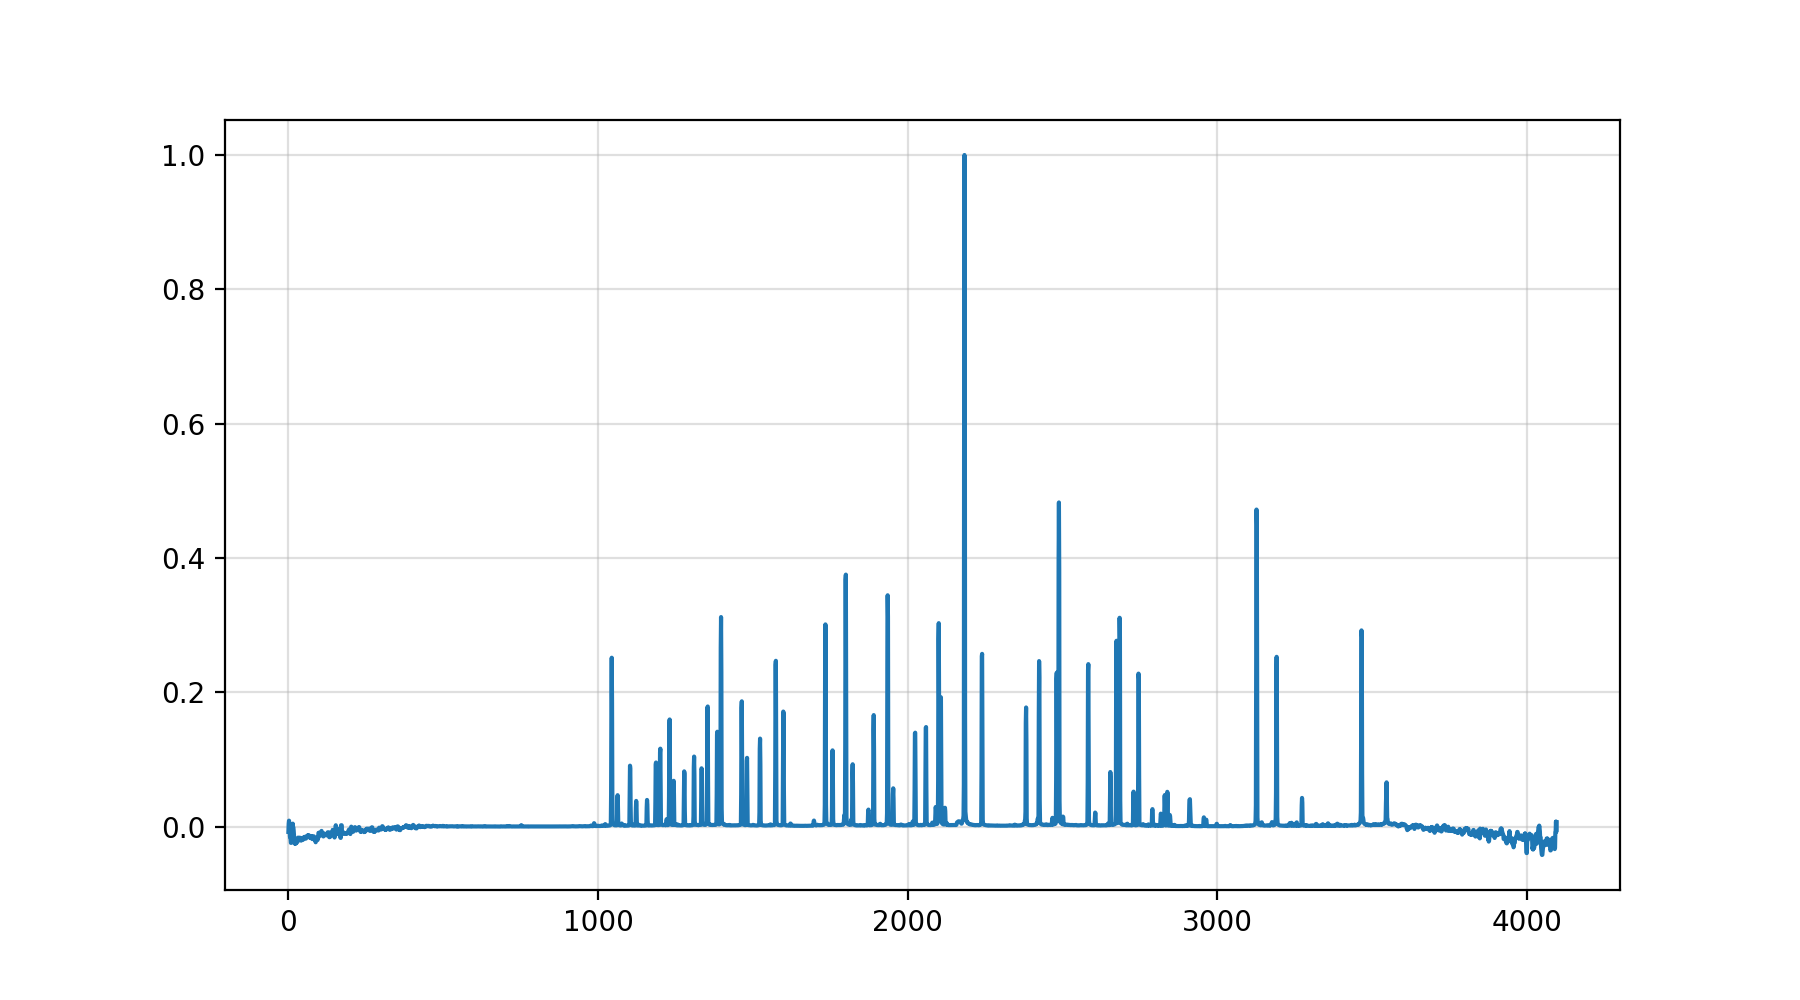

In [139]:
### create 1D arc spectrum
# mean_red_arc = np.median(red_arc[:,:], axis=0)
mean_red_arc = np.median(red_arc[185:195,:], axis=0)

## normalise the arc lines
maxval = np.max(mean_red_arc)
red_arc_normed = mean_red_arc/maxval

%matplotlib notebook

fig = plt.figure(figsize=(9,5))
plt.plot(red_arc_normed)

plt.grid(alpha=0.4)
plt.show()

<IPython.core.display.Javascript object>


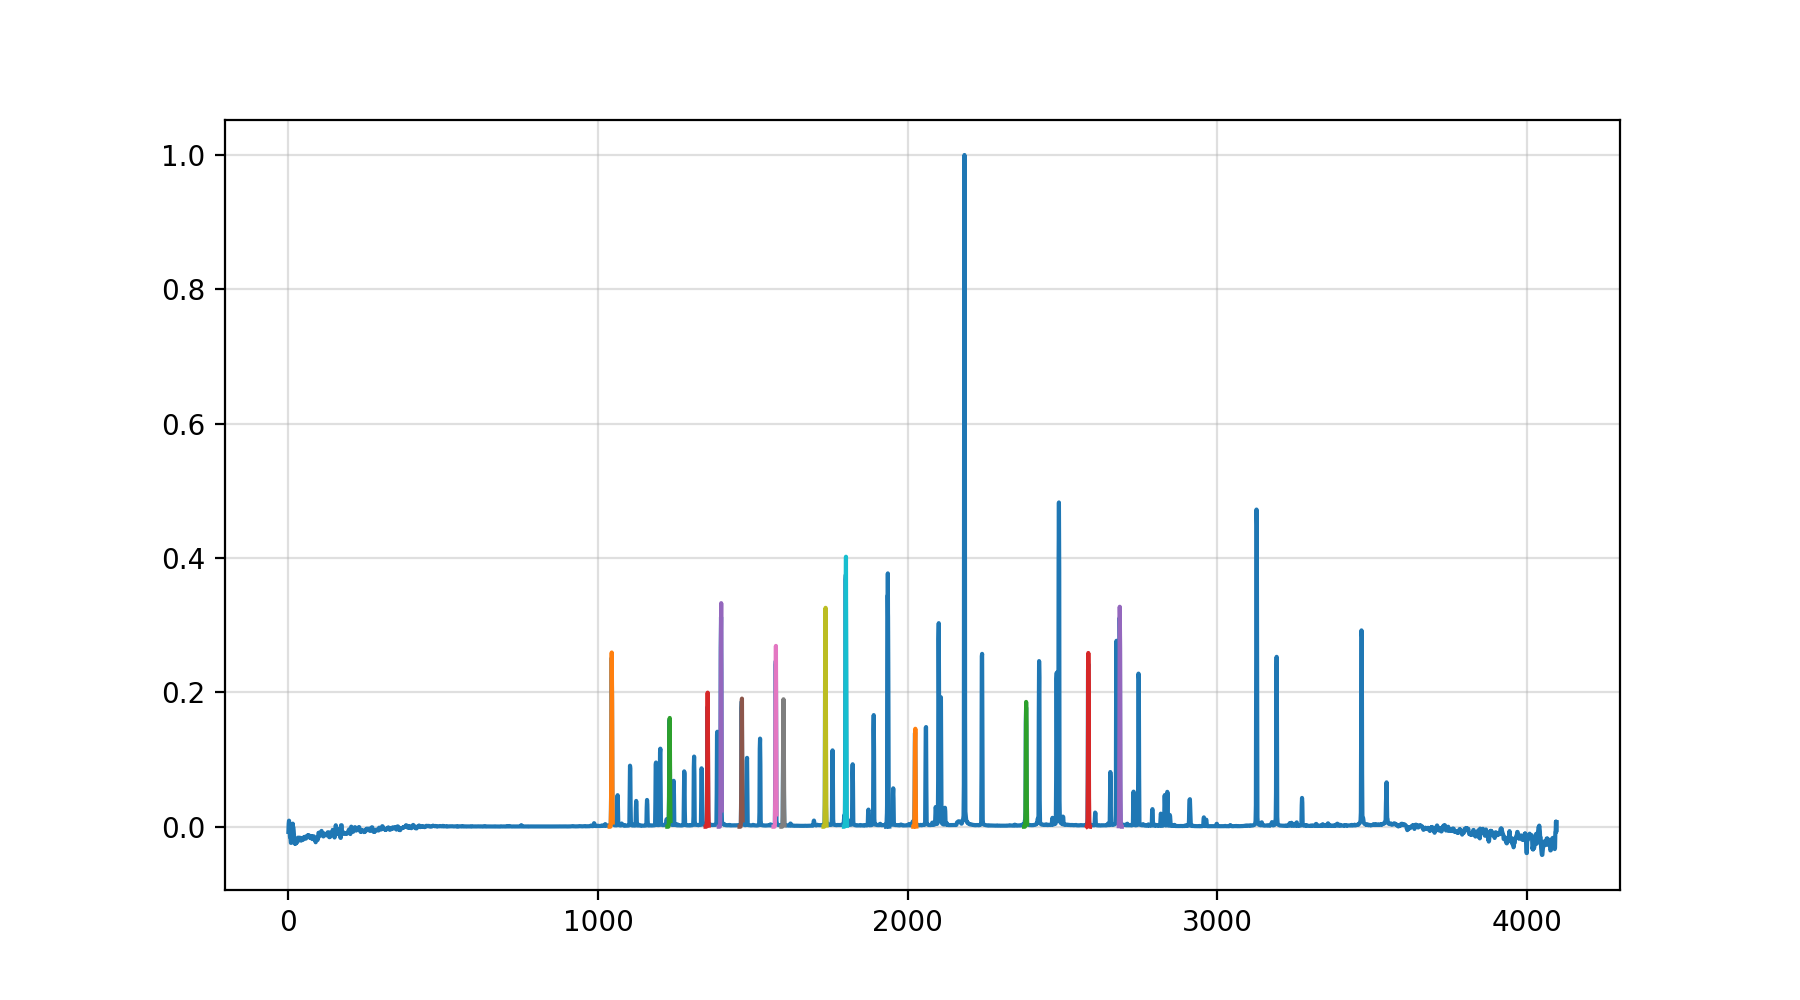

In [140]:
# Lines for the red arc
pixels_red = [1042.33, 1228.61, 1352.1, 1394.7, 1461.7, 1571.4, 1596.94,
              1732.9, 1798.7, 1935.0, 2022.74, 
              2380.47, 2583.5, 2686.1]

wavelengths_red = [5852.49, 6143.06, 6334.43, 6402.25, 6506.53, 6678.3, 6717.04,
                   6929.47, 7032.41, 7245.17, 7383.98, 
                   7948.17, 8264.52, 8424.65]


# Create x axis
xaxis = np.linspace(0,4200, 4200)

%matplotlib notebook

fig = plt.figure(figsize=(9,5))
plt.grid(alpha=0.4)
plt.plot(red_arc_normed)

line_pix = []

for pixel in pixels_red:
    # create gaussian to fit to the arc line
    p0 = [0.4, pixel, 3.0]
    coeffs, covar = optimize.curve_fit(gauss, xaxis[int(pixel-10):int(pixel+10)], red_arc_normed[int(pixel-10):int(pixel+10)], p0=p0, 
                                       bounds=([0.05, pixel-5, 1.0], [1.0, pixel+5, 6.0]))
    line_pix.append(coeffs[1])
    plt.plot(np.linspace(pixel-5, pixel+5, 10), gauss(np.linspace(pixel-5, pixel+5, 10), *coeffs))
    
    
sol_red = []
for i in range(len(wavelengths_red)):
    sol_red.append(wavelengths_red[i]-line_pix[i])

plt.grid(alpha=0.4)
plt.show()

# %matplotlib notebook
# plt.plot(line_pix, wavelengths_red)

[1.56875517e+00 4.21038159e+03]


<IPython.core.display.Javascript object>


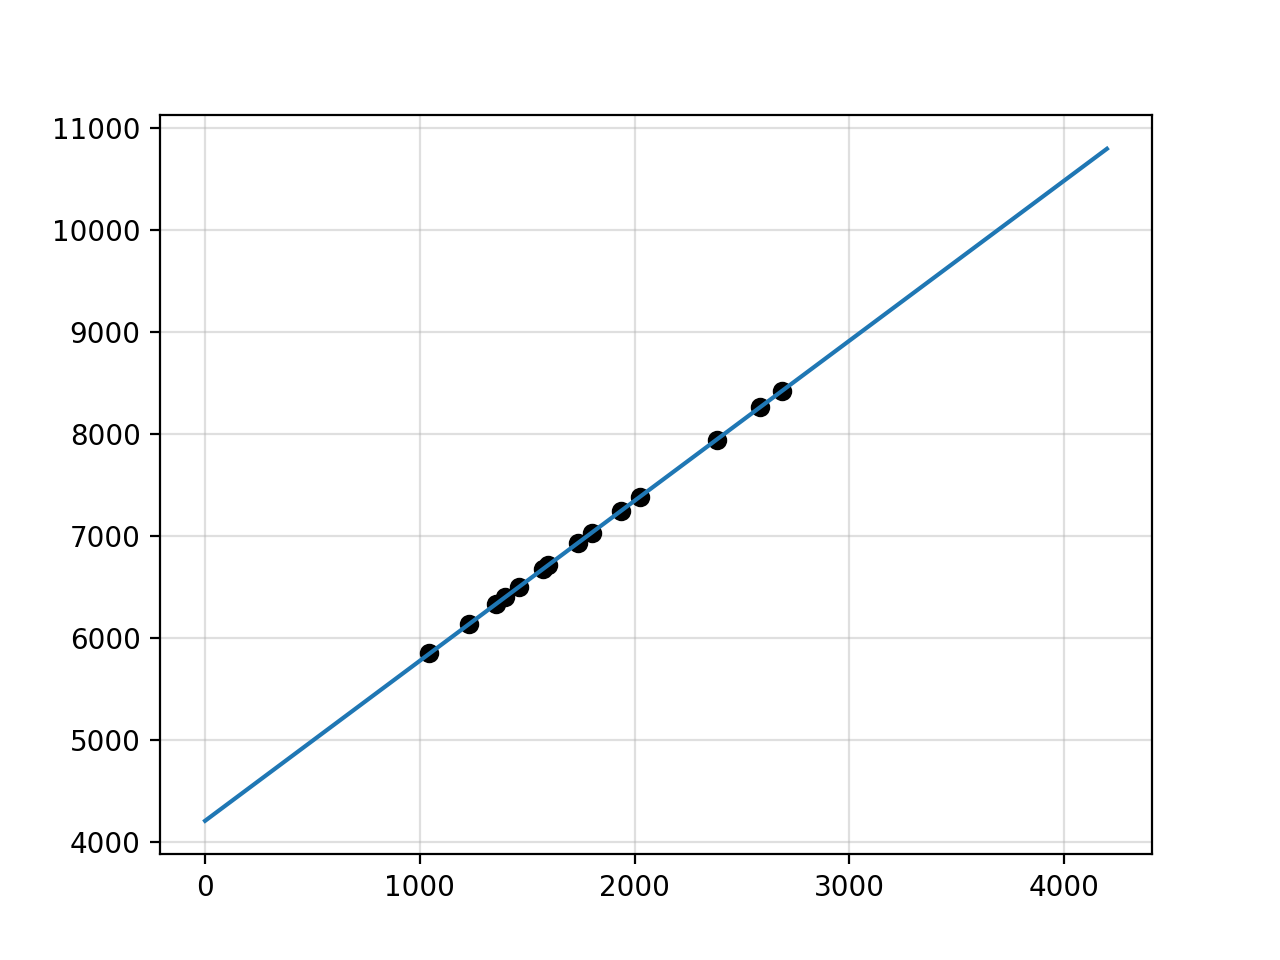

In [141]:
# Lets try and find a wavelength calibration solution
# Fit Red wavelength solutions

# initial guess
p0 = [1.4, 4440]

fit_red, cov_red = optimize.curve_fit(wavesol, line_pix, wavelengths_red, p0=p0)

print(fit_red)

wavered = wavesol(xaxis, *fit_red)

%matplotlib notebook

plt.plot(line_pix, wavelengths_red, 'ko')
plt.plot(xaxis, wavered)

plt.grid(alpha=0.4)

plt.show()

In [266]:
### Calculate CRPIX and CRDELT values based on new wavelength range and then update the header of the SCI file

target = 'SP1708+602'

# print(len(wavered))
# print(wavered[0], max(wavered))

# crval1 = wavered[0]
# cdelt1 = (wavered[-1]-wavered[0])/len(wavered)

### from known values
crval1 = 4215.210956910993
cdelt1 = 1.566343826578995
cunit1 = 'Angstrom'

print(crval1, cdelt1, cunit1)

## Update sci file
scidata, scihead = fits.getdata("./processed_new/FLUX/%s.fits" %target, header=True)

scihead['CRVAL1'] = crval1
scihead['CRVAL2'] = 1.0
scihead['CDELT1'] = cdelt1
scihead['CRPIX2'] = 185.0
scihead['CUNIT1'] = cunit1
scihead['CUNIT2'] = 'Arcsec'
scihead['CTYPE1'] = 'LINEAR'
scihead['CTYPE2'] = 'LINEAR'
scihead['CD1_1'] = cdelt1
scihead['CD2_2'] = 0.44
scihead['PV2_1'] = 1.0

fits.writeto("./processed_new/FLUX/%s_WC.fits" %target, scidata, header=scihead, overwrite=True)

print("Wavelength calibration complete.")

4215.210956910993 1.566343826578995 Angstrom
Wavelength calibration complete.


## Extraction of 1D spectrum from 2D

Import the WC 2D spectrum and extract a 1D spectrum using an aperture. We will save the output spectrum as an MPDAF Spectrum object

<IPython.core.display.Javascript object>


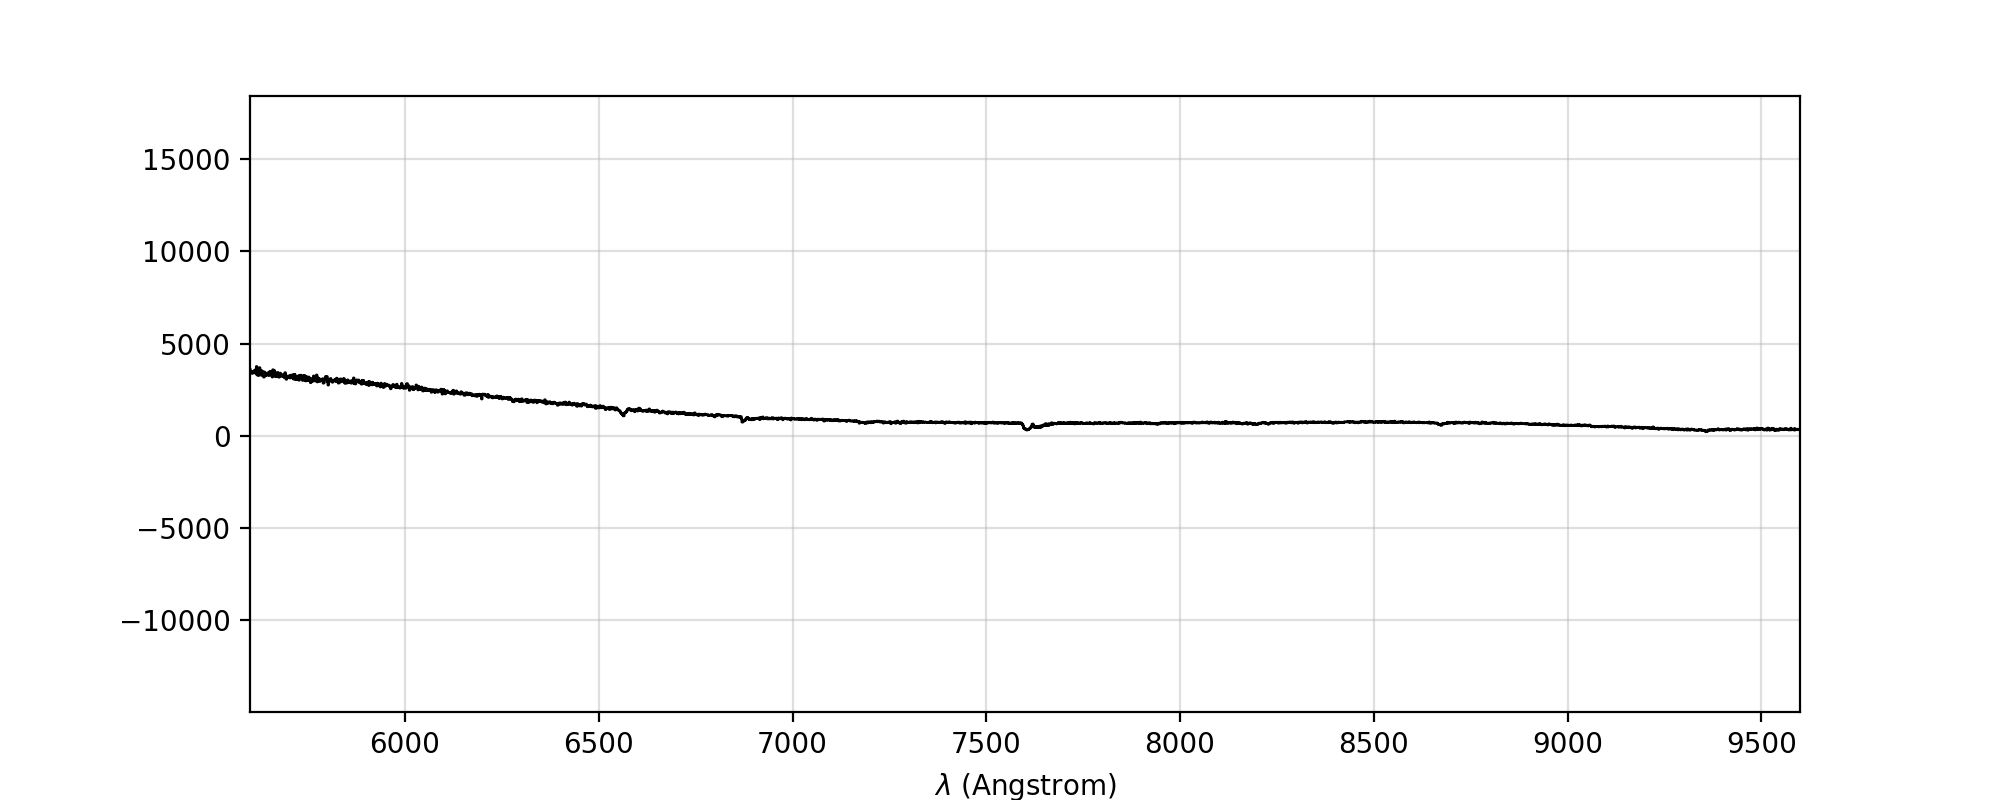

1D spectrum extracted


In [269]:
## Read in the 2D spectrum

# target = "SP1134+300"
spec2d, spechead = fits.getdata("./processed_new/FLUX/%s_WC.fits" %target, header=True)

## Read in the wavelength axis values
cdelt = spechead['CDELT1']
crval = spechead['CRVAL1']

wavelength_1d = WaveCoord(cdelt=cdelt, crval=crval, cunit=u.Angstrom)

central_pix = 185
aperture = 5

spectrum_1d = np.sum(spec2d[central_pix-aperture:central_pix+aperture,:], axis=0)
# print(np.shape(spectrum_1d))

spectrum_mpdaf = Spectrum(wave=wavelength_1d, data=spectrum_1d, data_header=spechead)

%matplotlib notebook
fig = plt.figure(figsize=(10,4))
plt.grid(alpha=0.4)

spectrum_mpdaf.rebin(1).plot(color='k')
plt.xlim(5600, 9600)
# plt.ylim(-20,100)

### Show lines
# z = 6.246
# plt.axvline(1216.0*(1+z), color='k', ls='--', alpha=0.5)
# plt.axvline(1037.6*(1+z), color='k', ls='--', alpha=0.5)
# plt.axvline(949.74*(1+z), color='k', ls='--', alpha=0.5)
# plt.axvline(1240.*(1+z), color='k', ls='--', alpha=0.5)
# plt.axvline(1302.*(1+z), color='k', ls='--', alpha=0.5)
# #plt.axvline(7452.538*(1+z), color='k', ls='--', alpha=0.5)

# plt.savefig("./processed_new/FLUX/%s_1D.png" %target, overwrite=True)
plt.show()

spectrum_mpdaf.write("./processed_new/FLUX/%s_1D.fits" %target)

print("1D spectrum extracted")

## Flux calibration

In [147]:
#######################
objects = ["SP1708+602"] # Enter flux calibrator object name(s) (see from observing log)
#######################

try:
    os.mkdir("./processed_new/FLUX/")
except OSError:
    pass

### Ignore masked array warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Refresh the file list to include new exposures
ic1 = ImageFileCollection(workdir)
    
### Reduce science frame
for objname in objects:
    print("Reducing:", objname)
    target_list = []
    for ifx, filename in enumerate(ic1.files_filtered(obstype='TARGET', object=objname)):
        print('{0} {1}'.format(ifx+1, filename))
        hdu = fits.open(ic1.location + filename)
        ccd = CCDData(hdu[1].data, header=hdu[0].header+hdu[1].header, unit = u.adu)
        #this has to be fixed as the bias section does not include the whole section that will be trimmed

        ccd = ccdproc.cosmicray_lacosmic(ccd, sigclip=4., niter=10, sigfrac=0.3, psffwhm=2.5, 
                                         gain=ccd.header['GAIN'], readnoise=ccd.header['READNOIS'])
        ccd = ccdproc.subtract_overscan(ccd, median=True,  overscan_axis=0, fits_section=ccd.header['BIASSEC'])
        ccd = ccdproc.trim_image(ccd, fits_section=ccd.header['TRIMSEC'] )
        ccd = ccdproc.subtract_bias(ccd, master_bias)
        ccd = ccdproc.flat_correct(ccd, master_skyflat)


        # Do sky subtraction
        # ccd.mask[:,690:700] = True
        sky = fit_background(np.ma.array(ccd.data, mask=ccd.mask))
        ccd.data -= sky

        # Rotate Frame

        ccd.data = ccd.data.T
        ccd.mask = ccd.mask.T
        #ccd.write('obj_'+filename, overwrite=True)
        target_list.append(ccd)

    red_target = ccdproc.combine(target_list, method='median')

    red_target.write('./processed_new/FLUX/{0}.fits'.format(target_list[0].header['object']), overwrite=True)

    print("Reduced object")

Reducing: SP1708+602


IndexError: list index out of range

In [270]:
## Read in the standard star spectrum

fluxdata = np.loadtxt("./processed/FLUX/SP1708+602.txt")

wave = np.zeros(len(fluxdata))
flux_AB = np.zeros(len(fluxdata))
flux = np.zeros(len(fluxdata))

for i in range(len(fluxdata)):
    wave[i] = fluxdata[i][0]
    flux_AB[i] = fluxdata[i][1]
    flux_Jy = 10**(-(flux_AB[i] - 8.9)/2.5) # Flux in Jy
    flux_nu = flux_Jy * 1e-23
    flux[i] = flux_nu * (3e18)/(wave[i]**2)

<IPython.core.display.Javascript object>


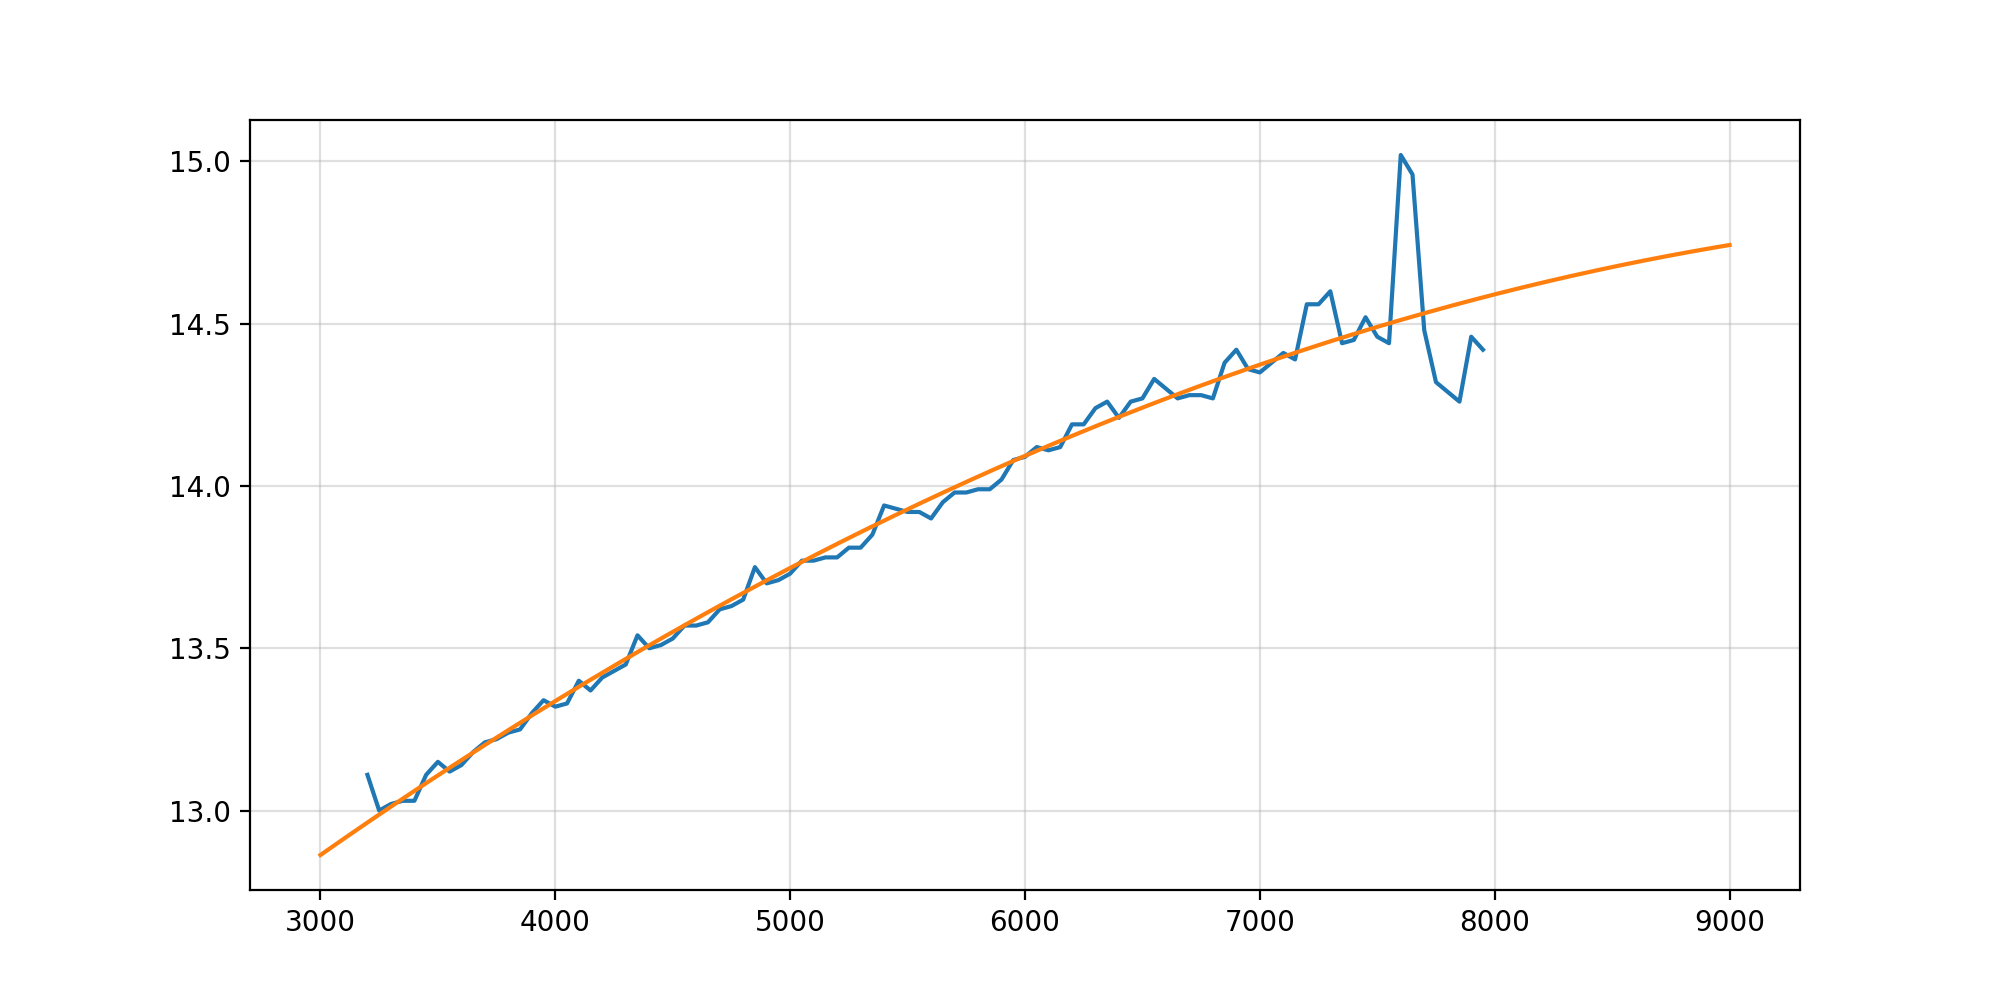

In [271]:
## Fit polynomial to the spectrum to visualise the fitting.
## Play around with the type of polynomial and/or degree until satisfied with the fit 
cont = np.polyfit(wave, flux_AB, 2)

xaxis = np.linspace(3000, 9000, 1000)
fluxpol = np.polyval(cont, xaxis)

%matplotlib notebook
fig = plt.figure(figsize=(10,5))
plt.grid(alpha=0.4)

plt.plot(wave, flux_AB)
plt.plot(xaxis, fluxpol)

# plt.yscale('log')
plt.show()

201


<IPython.core.display.Javascript object>


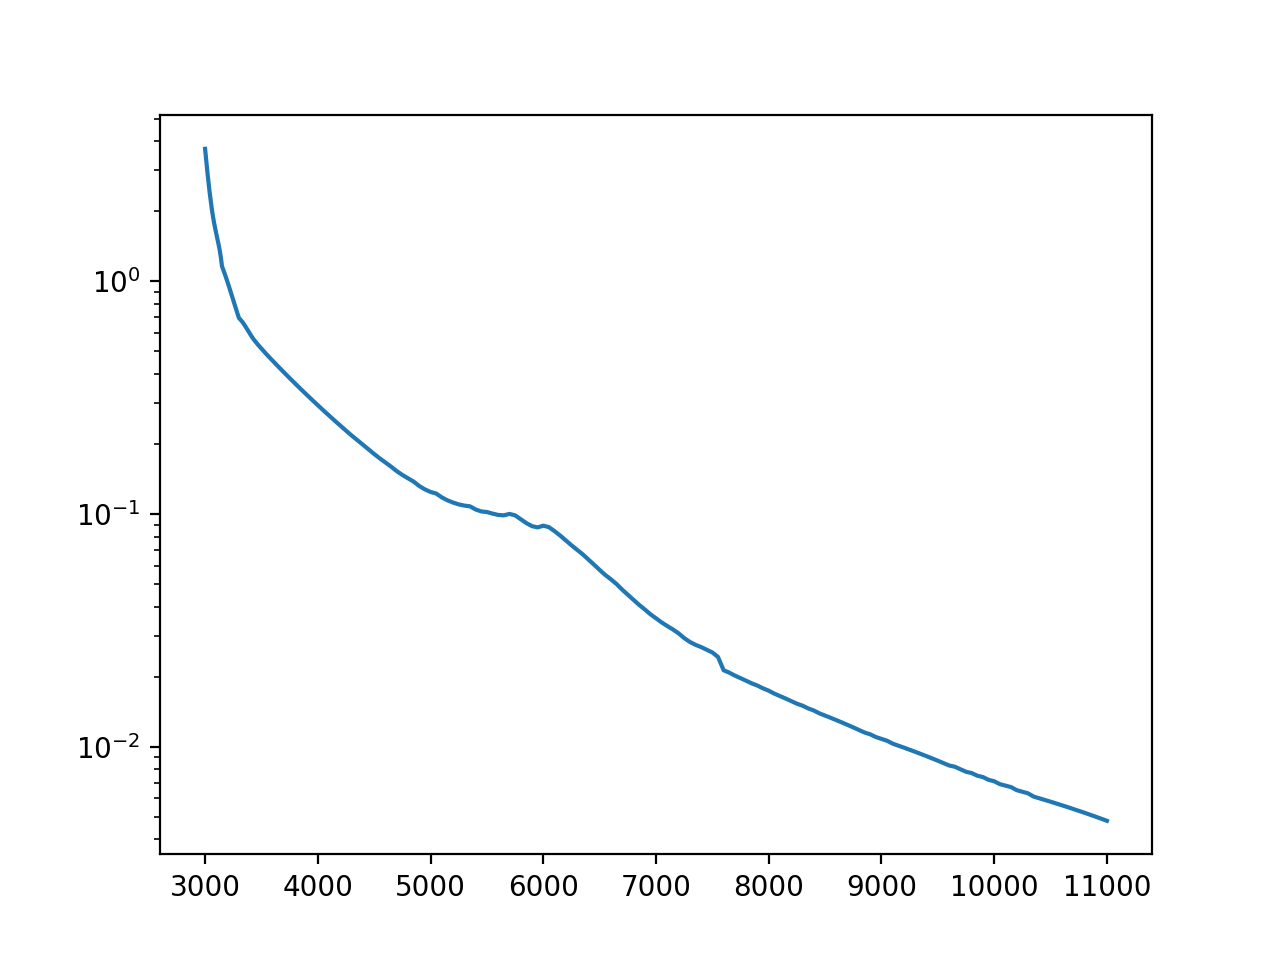

In [272]:
### Look at atmopheric extinction curve
data = np.loadtxt("/Users/aayushsaxena/Desktop/phd/HzQ_2019/Data/extinction.dat.txt")

print(len(data))

w_corr = np.zeros(len(data))
fcorr_AB = np.zeros(len(data))
f_corr = np.zeros(len(data))

### convert the extinction magnitude into flux density
### Add the flux density to the final calibrated flux, taking also into account the airmass

# for i in range(len(data)):
#     wl.append(data[i][0])
#     ext.append(data[i][1])
    
for i in range(len(data)):
    w_corr[i] = (data[i][0])
    fcorr_AB[i] = data[i][1]
#     flux_Jy = 10**(-(f_AB[i] - 8.9)/2.5) # Flux in Jy
#     flux_nu = flux_Jy * 1e-23
#     f_corr[i] = flux_nu * (3e18)/(w_corr[i]**2)
    
%matplotlib notebook
plt.plot(w_corr, fcorr_AB)

plt.yscale('log')

# plt.xlim(5000, 9600)
# plt.ylim(0.0, 0.2)

plt.show()

<IPython.core.display.Javascript object>


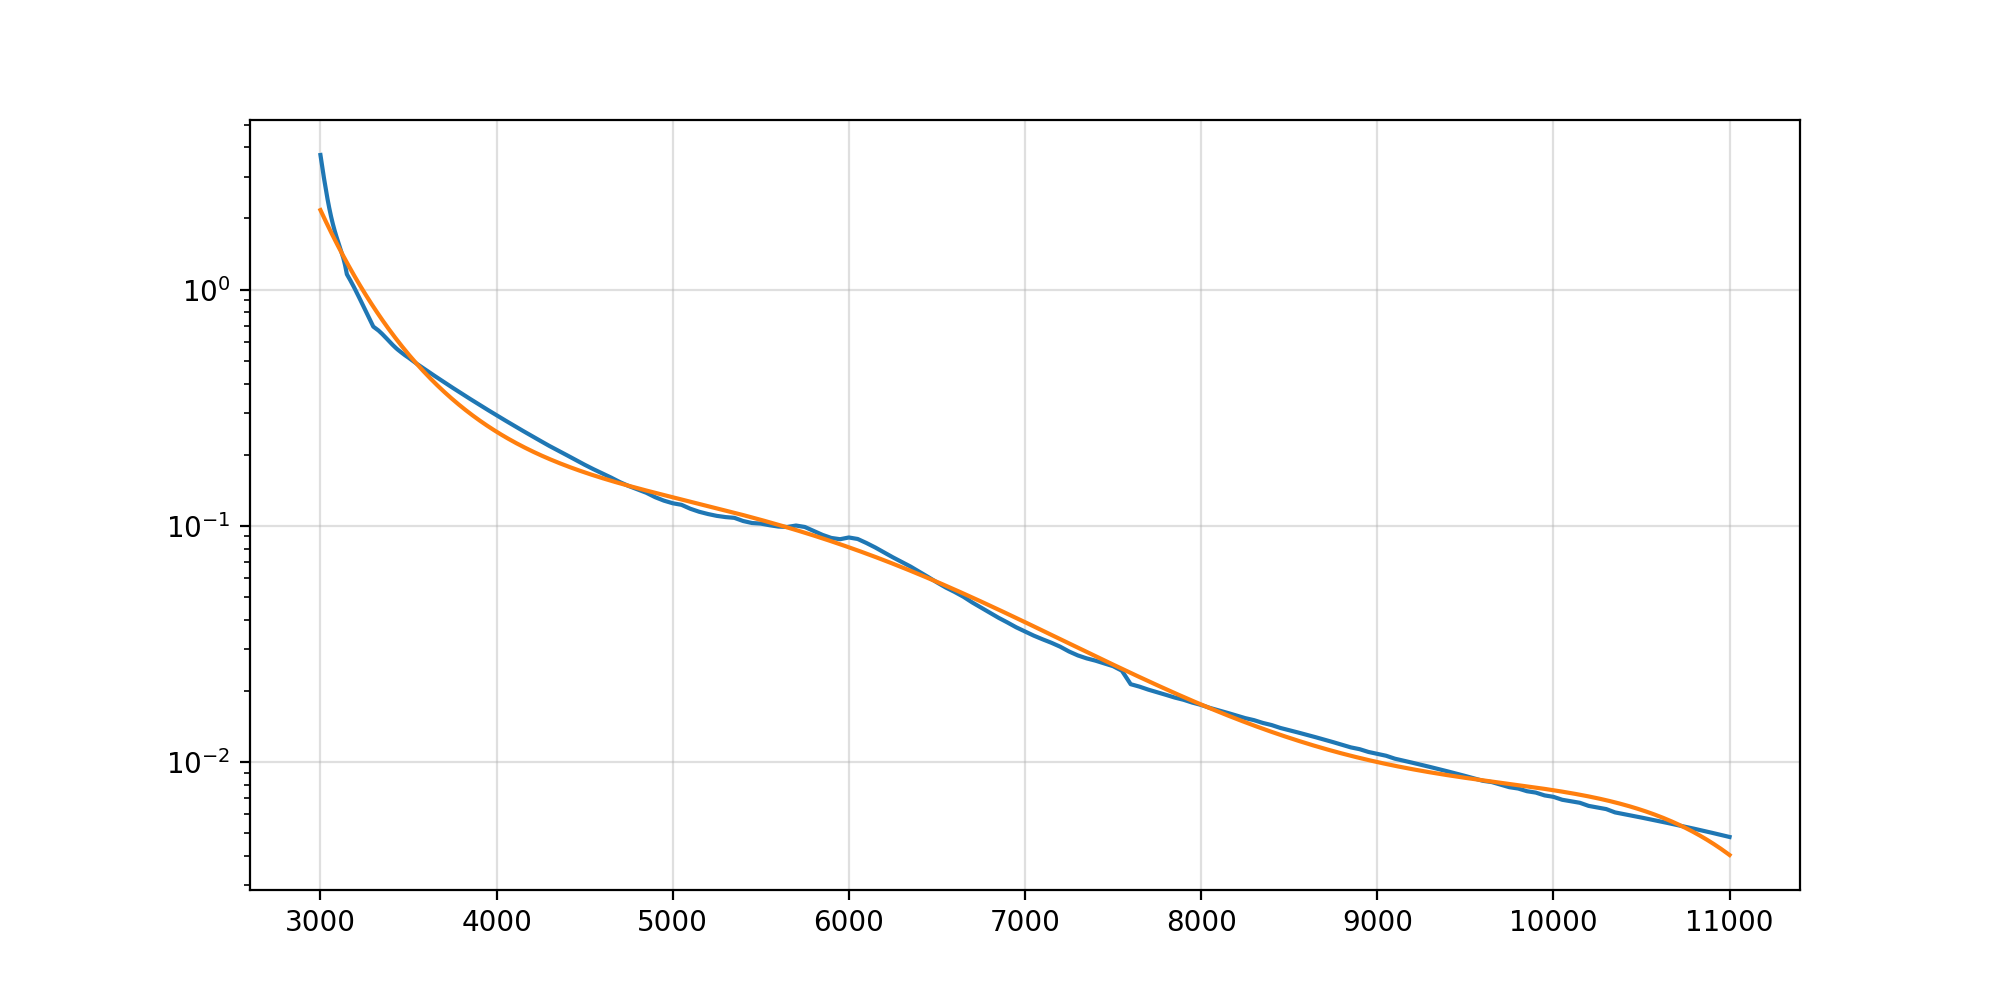

In [275]:
## Fit polynomial to the spectrum to visualise the fitting.
## Play around with the type of polynomial and/or degree until satisfied with the fit 
extinction = np.polyfit(w_corr, np.log10(fcorr_AB), 5)

xcorr= np.linspace(3000, 11000, 1000)
extpol = np.polyval(extinction, xcorr)

%matplotlib notebook
fig = plt.figure(figsize=(10,5))
plt.grid(alpha=0.4)

plt.plot(w_corr,fcorr_AB)
plt.plot(xcorr, 10**(extpol))

plt.yscale('log')
plt.show()

<IPython.core.display.Javascript object>


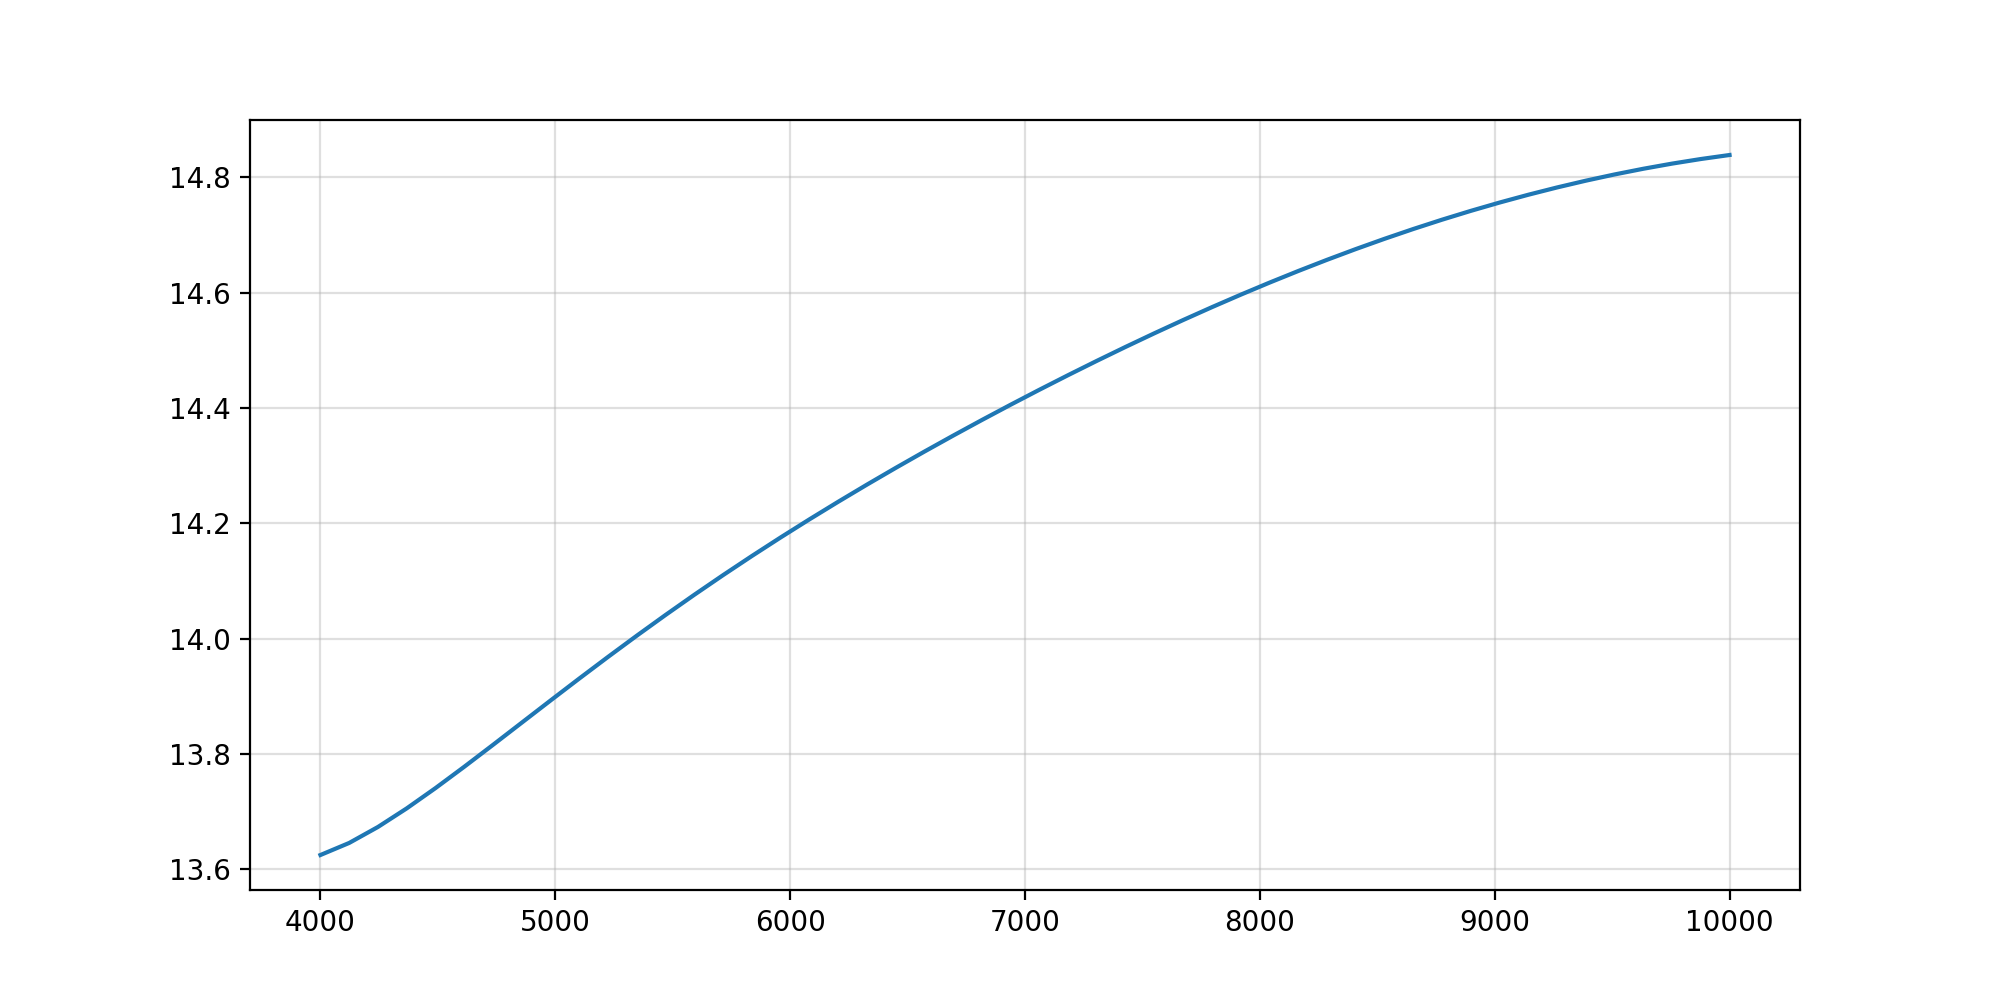

In [276]:
### Let's fold in the atmospheric extinction correction to obtain the "observed" spectrum
### which will then be compared with the extracted 1D

### m(λ)=m0(λ)+κ(λ)X(z)

x_obs = np.linspace(4000, 10000)
obs_AB = np.zeros(len(x_obs))

########
airmass = 1.15
########

### Evaluate polynomials on the new xaxis
stdflux = np.polyval(cont, x_obs)
corrflux = np.polyval(extinction, x_obs)

for i in range(len(x_obs)):
    obs_AB[i] = (stdflux[i]) + (10**(corrflux[i]) * airmass)

### Display the extinction corrected flux standard
%matplotlib notebook
fig = plt.figure(figsize=(10,5))
plt.grid(alpha=0.4)

# plt.plot(wave,flux_AB)
plt.plot(x_obs, obs_AB)

# plt.yscale('log')
plt.show()

<IPython.core.display.Javascript object>


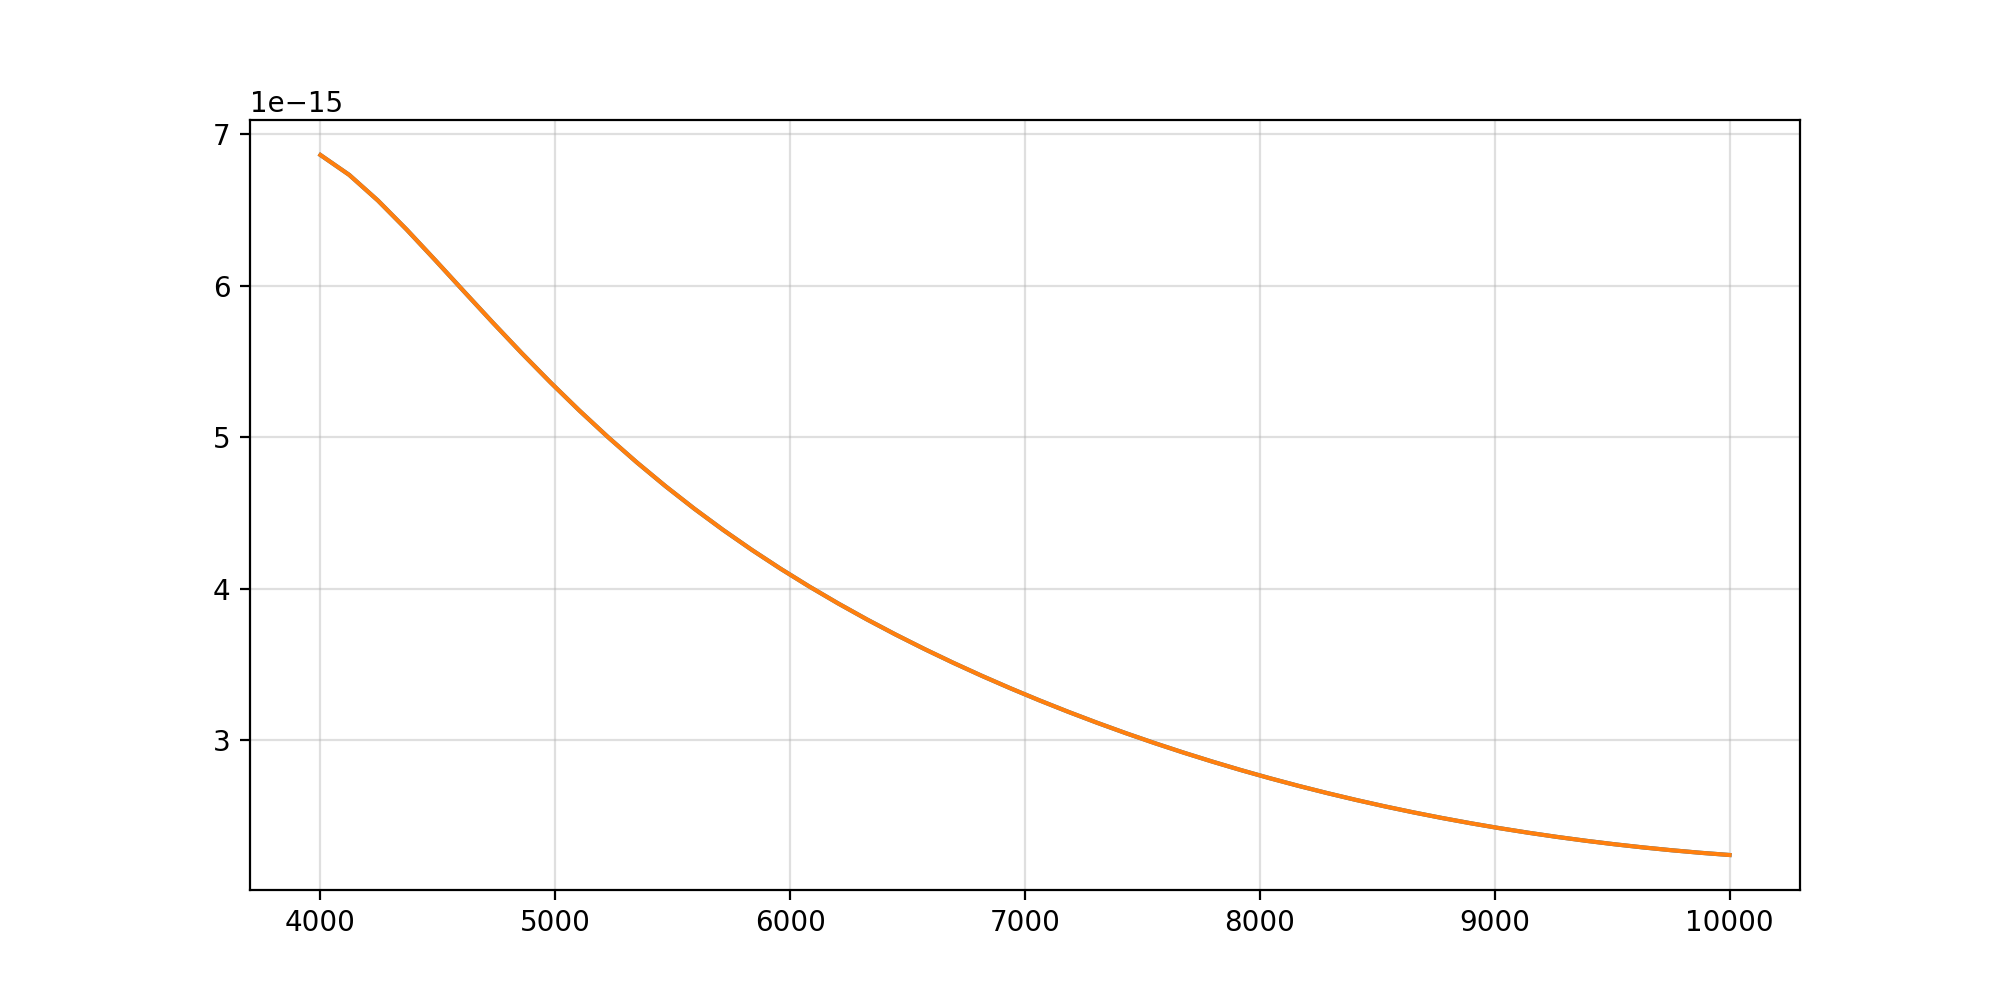

In [277]:
### Now convert the ext corrected flux of standard star to erg/s

flux = np.zeros(len(x_obs))

for i in range(len(flux)):
    flux_Jy = 10**(-(obs_AB[i] - 8.9)/2.5) # Flux in Jy
    flux_nu = flux_Jy * 1e-23
    flux[i] = flux_nu * (3e18)/(7505**2)
    
### Fit a function to this new spectrum

flux_polfit = np.polyfit(x_obs, np.log10(flux), 11)
fluxstd_pol = np.polyval(flux_polfit, x_obs)

%matplotlib notebook
fig = plt.figure(figsize=(10,5))
plt.grid(alpha=0.4)

plt.plot(x_obs, flux)
plt.plot(x_obs, 10**(fluxstd_pol))

# plt.yscale('log')
plt.show()

[ 4215.21095691  4216.77730074  4218.34364456 ... 10789.15599706
 10790.72234089 10792.28868472]


<IPython.core.display.Javascript object>


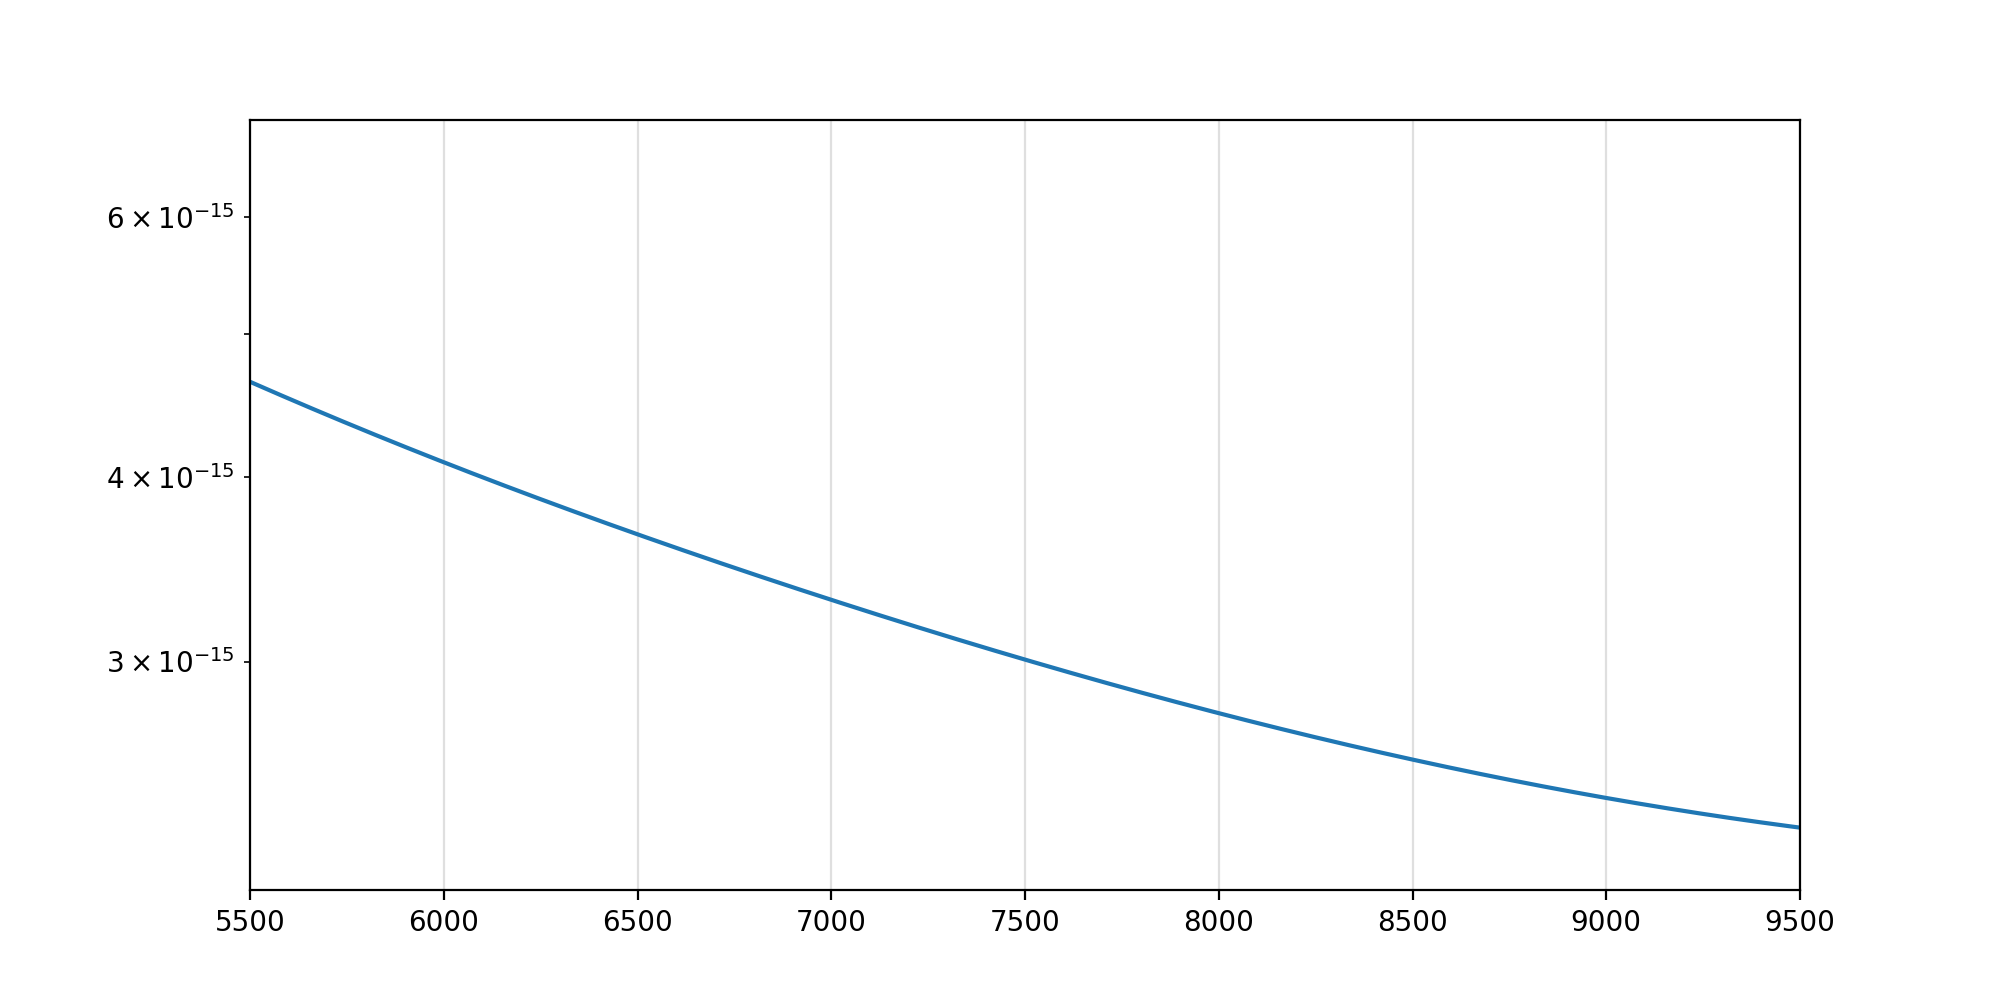

In [278]:
## Let's convert this into a mpdaf spectrum

## Create a fake wavelength axis, using the crval and crdelt values from the flux standard WHT spectrum
## Using the fitted Chebyshev functions, calculate the flux and then create and mpdaf spectrum.
## Then create subspectra in the wavelength range probed and calculate a response function.
## This response function must then be applied to the extracted 1D spectra, accounting for exposure times

## import the actual observation of the flux standard to use as template for the mpdaf spectrum
fluxspec, fluxhead = fits.getdata("./processed_new/FLUX/SP1708+602_1D.fits",
                                  header=True)

crval = fluxhead['CRVAL1']
cdelt = fluxhead['CDELT1']

xaxis = np.zeros(len(fluxspec))

xaxis[0] = crval

for i in range(1, len(xaxis)):
    xaxis[i] = xaxis[i-1] + cdelt
    
print(xaxis) # fake x axis defined
                                  
## Assign fake flux using the fitted polynomials
fluxstd = np.zeros(len(xaxis))
fluxstd = 10**(np.polyval(flux_polfit, xaxis))

%matplotlib notebook

fig = plt.figure(figsize=(10,5))
plt.grid(alpha=0.4)

plt.plot(xaxis, fluxstd)
plt.xlim(5500, 9500)
plt.yscale('log')
# plt.ylim(1e-16, 1e-13)
plt.show()

<IPython.core.display.Javascript object>


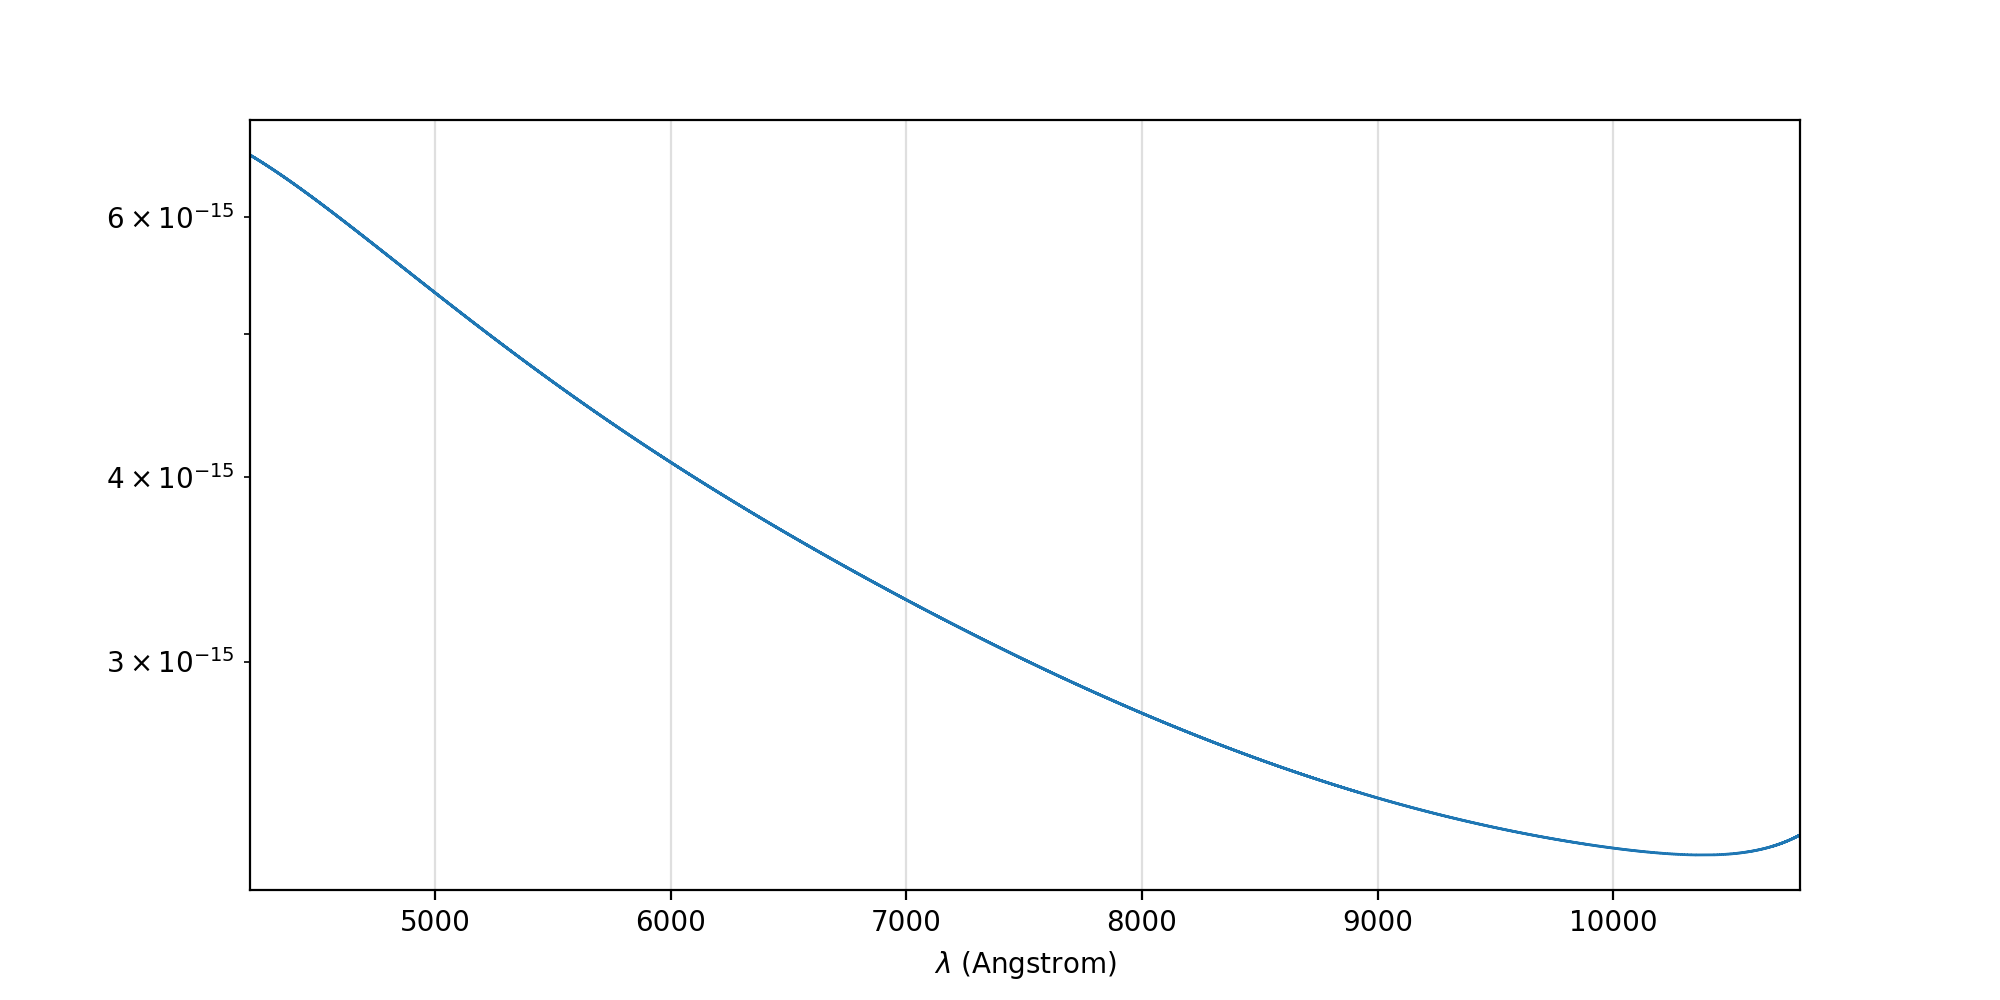

In [279]:
### Create the mpdaf spectrum
fluxwave = WaveCoord(cdelt = cdelt, crval = crval, cunit = u.Angstrom)
fluxspec = Spectrum(wave=fluxwave, data=fluxstd)

## Show the mpdaf spectrum
%matplotlib notebook

fig = plt.figure(figsize=(10,5))
plt.grid(alpha=0.4)

fluxspec.plot()
plt.yscale('log')

plt.show()

4200
4200


<IPython.core.display.Javascript object>


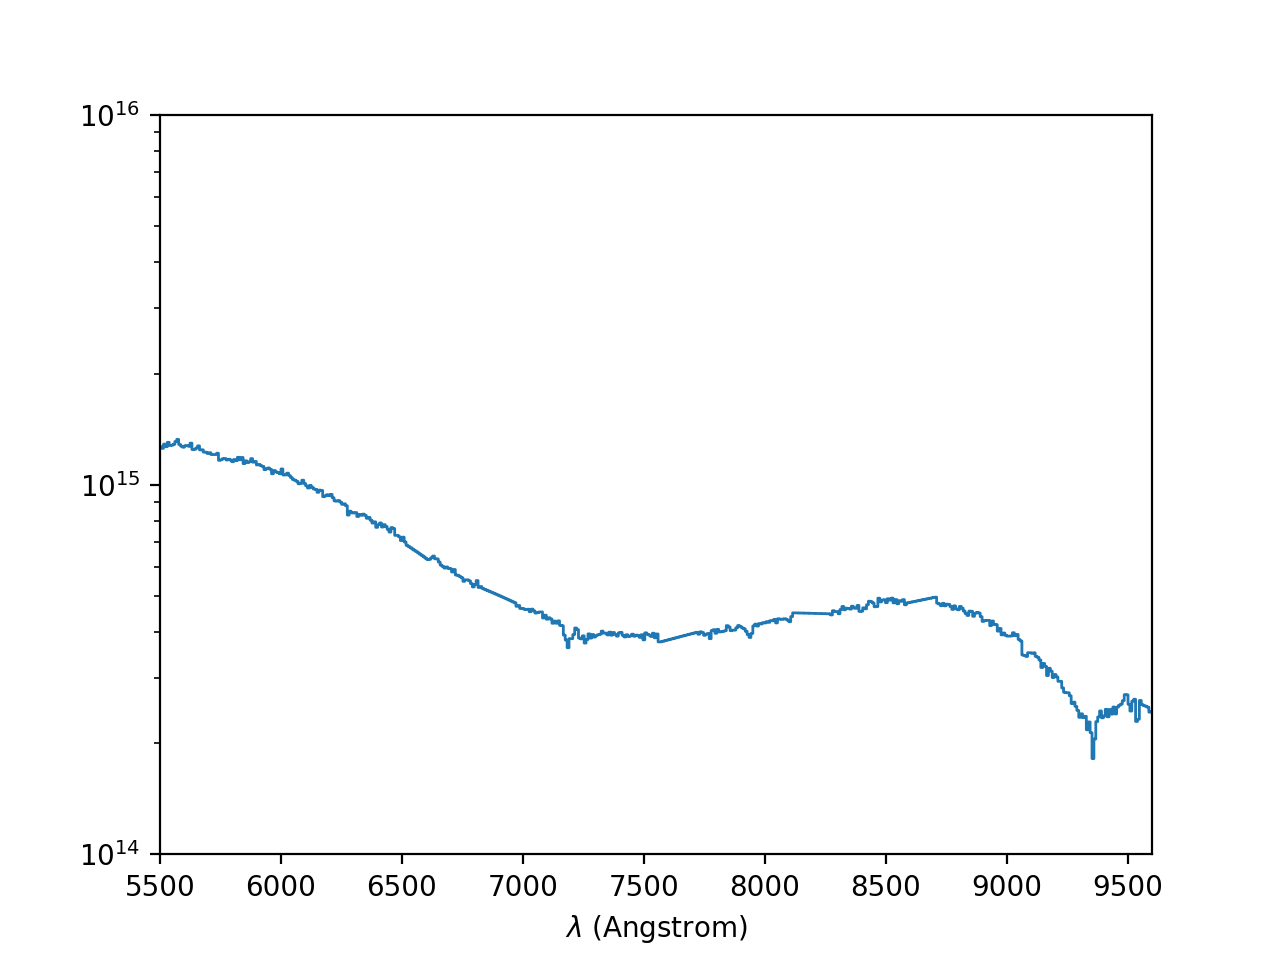

In [280]:
## RED ARM
## Load in the 1D extracted spectrum of the flux standard

spec1d = Spectrum("./processed_new/FLUX/SP1708+602_1D.fits")
flux_exp = 600.

### Let's extract a subspectrum from the original flux standard spectrum to match the targets
### First rebin with the same wavelength delta

print(len(fluxspec.data))
print(len(spec1d.data))

### Mask bad regions
spec1d.mask_region(lmin=7563, lmax=7720, unit=u.angstrom)
spec1d.mask_region(lmin=6514, lmax=6613, unit=u.angstrom)
spec1d.mask_region(lmin=6836, lmax=6968, unit=u.angstrom)
# spec1d.mask_region(lmin=7720, lmax=7977, unit=u.angstrom)
spec1d.mask_region(lmin=8112, lmax=8270, unit=u.angstrom)
# # spec1d.mask_region(lmin=8498, lmax=8820, unit=u.angstrom)
spec1d.mask_region(lmin=8580, lmax=8710, unit=u.angstrom)

# spec1d.mask_region(lmin=8921, lmax=9041, unit=u.angstrom)


spec1d.interp_mask()

# fluxspec = fluxstd_spec.resample(1.719097201253421, unit=u.Angstrom)
# fluxspec_sub = fluxstd_spec.subspec(lmin=5000, lmax=9400, unit=u.Angstrom)
# spec1d_sub = spec1d.subspec(lmin=5000, lmax=9400, unit=u.Angstrom)

response_red = (spec1d.data/flux_exp) / fluxspec.data # (counts/s) / flux

responsespec = Spectrum(wave=spec1d.wave, data=response_red)
# responsespec = Spectrum("./processed/FLUX/response.fits")

%matplotlib notebook

responsespec.rebin(5).plot()
plt.ylim(1e14, 1e16)
plt.xlim(5500, 9600)

plt.yscale('log')
plt.show()

## Save the response spectrum
# responsespec.rebin(5).write("./processed/FLUX/response.fits")

In [283]:
### Response calculated. Now let us import target data, make a subspec between the wavelength and calibrate

obj_name = "P144+50"

scispec = Spectrum("./processed_new/SCI/%s_1D_new.fits" %obj_name)
sci_exptime = 7200.

# Apply the response curve
scispec_fc = (scispec.data/sci_exptime) / responsespec.data


### Calculate noise from the 2D image too
night_new, night_head = fits.getdata("/Users/aayushsaxena/Desktop/phd/HzQ_2019/P144+50/P144+50_WC_new.fits",
                                    header=True)

## Read in the wavelength axis values
cdelt = night_head['CDELT1']
crval = night_head['CRVAL1']

### Define wavelength axis for noise sepctrum
wavelength = WaveCoord(cdelt=cdelt, crval=crval, cunit=u.Angstrom)

central_pix1 = 210
aperture1 = 5
noise1 = np.sum(night_new[central_pix1-aperture1:central_pix1+aperture1,:], axis=0)

central_pix2 = 165
aperture2 = 5
noise2 = np.sum(night_new[central_pix2-aperture2:central_pix2+aperture2,:], axis=0)

noise = np.mean([noise1, noise2], axis=0)

noise_spec = Spectrum(wave=wavelength, data=noise)

### Flux calibrate the noise
### add sky plus poissonian noise
noise_fc = (np.sqrt(scispec.data)/sci_exptime) / responsespec.data


# Create new spectrum object using the flux calibrated values and add error
scispec_1d = Spectrum(wave=scispec.wave, data=scispec_fc, var=noise_fc, unit=u.erg/(u.s * u.cm**2 * u.Angstrom))

noisespec_1d = Spectrum(wave=scispec.wave, data=noise_fc, unit=u.erg/(u.s * u.cm**2 * u.Angstrom))

print("Flux calibrated spectrum produced!")

Flux calibrated spectrum produced!


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt


<IPython.core.display.Javascript object>


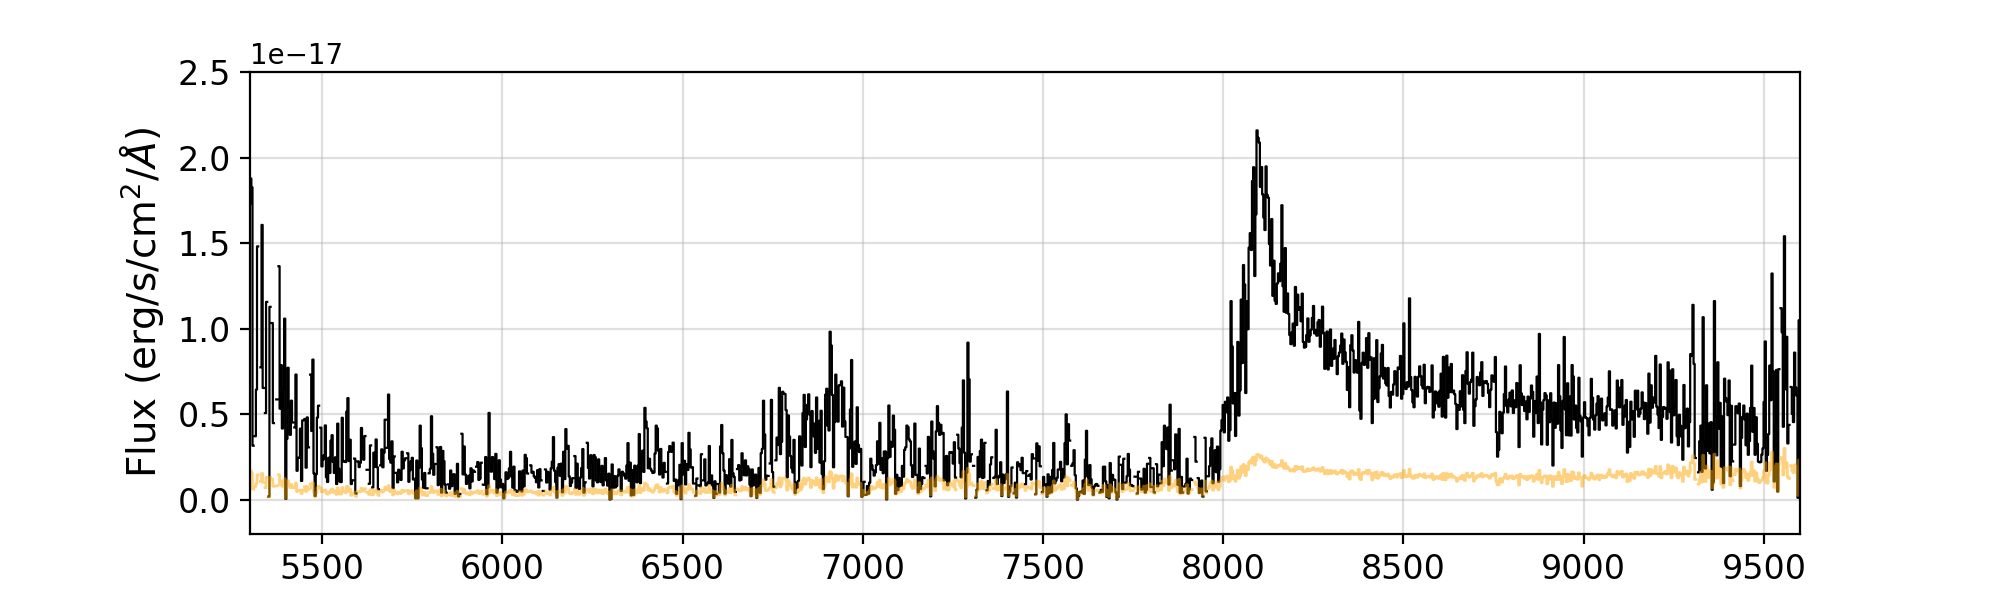

In [286]:
### Show FC spectrum

%matplotlib notebook
fig = plt.figure(figsize=(10,3))
plt.grid(alpha=0.4)

scispec_1d.rebin(2).plot(c='k', linewidth=0.8)
noisespec_1d.rebin(2).plot(c='orange', alpha=0.5)

plt.ylim(-0.2e-17,2.5e-17)
plt.xlim(5300, 9600)

plt.xlabel(r"Wavelength ($\AA$)", fontsize=14)
plt.ylabel(r"Flux (erg/s/cm$^2$/$\AA$)", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig("./processed_new/SCI/%s_1D_FC.png" %obj_name, dpi=200, bbox_inches="tight", overwrite=True)

plt.show()


# Save the flux calibrated spectrum
# scispec_1d.write("./processed/SCI/%s_1D_FC.fits" %obj_name)

In [287]:
### Save the flux calibrated subspectrum in the wavelength ranges that are covered
specfc_sub = scispec_1d.subspec(lmin=5300, lmax=9600, unit=u.angstrom)

specfc_sub.write("./processed_new/SCI/P144+50_1D_FC.fits")
# %matplotlib notebook
# specfc_sub.plot()

## Stack 1D observations

Take the extracted 1D spectra and do a summed stack in a bid to enhance signal to noise. Important to take note of the total exposure time when flux calibrating.

In [5]:
## Load in the spectra

specdir = "/Users/aayushsaxena/Desktop/phd/HzQ_2019/Data/INT_2019B/"

os.chdir(specdir)

spec1 = Spectrum("./20190526/processed/SCI/P144+50_1D.fits")
spec2 = Spectrum("./20190523/processed/SCI/P144+50_1D.fits")
spec3 = Spectrum("../20190406/trimmed/processed/SCI/P144+50_1D.fits")

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
Changed DATE-OBS from '2019-05-27        ' to '2019-05-27T00:00:00.0''. [astropy.wcs.wcs]
Changed DATE-OBS from '2019-05-24        ' to '2019-05-24T00:00:00.0''. [astropy.wcs.wcs]
Changed DATE-OBS from '2019-04-07        ' to '2019-04-07T00:00:00.0''. [astropy.wcs.wcs]


In [1]:
### Add the two spectra

stack_data = spec1.data+spec2.data+spec3.data
stack_spec = Spectrum(wave=spec1.wave, data=stack_data)


%matplotlib notebook
fig = plt.figure(figsize=(10,3), dpi=100)
plt.grid(alpha=0.4)

(stack_spec/227.5).rebin(2).plot(color='k')

plt.xlim(6000, 9500)
plt.ylim(-0.2,1.2)

plt.xlabel(r"Wavelength ($\AA$)", fontsize=12)
plt.ylabel("Flux (arbitrary units)", fontsize=12)

### Show lines
lines = [1025.7, 1034.8, 1215.7, 1240.8, 1262.6]
line_names = [r"Ly$\beta$", "O VI", r"Ly$\alpha$", "N V", "Si II"]
redshift = 5.66

for i in range(len(lines)):
    line_x = lines[i]*(1+redshift)
    plt.axvline(x=line_x, ls='--', c='k', alpha=0.5)
    plt.text(line_x+7, 1.0, line_names[i], fontsize=8, rotation=90)
    
# stack_spec.write("/Users/aayushsaxena/Desktop/phd/HzQ_2019/P144+50_stacked_1D.fits")
    
# plt.savefig("/Users/aayushsaxena/Desktop/phd/HzQ_2019/P144+50_stacked_1D.png", bbox_inches="tight", overwrite=True)

plt.show()

NameError: name 'spec1' is not defined

<IPython.core.display.Javascript object>


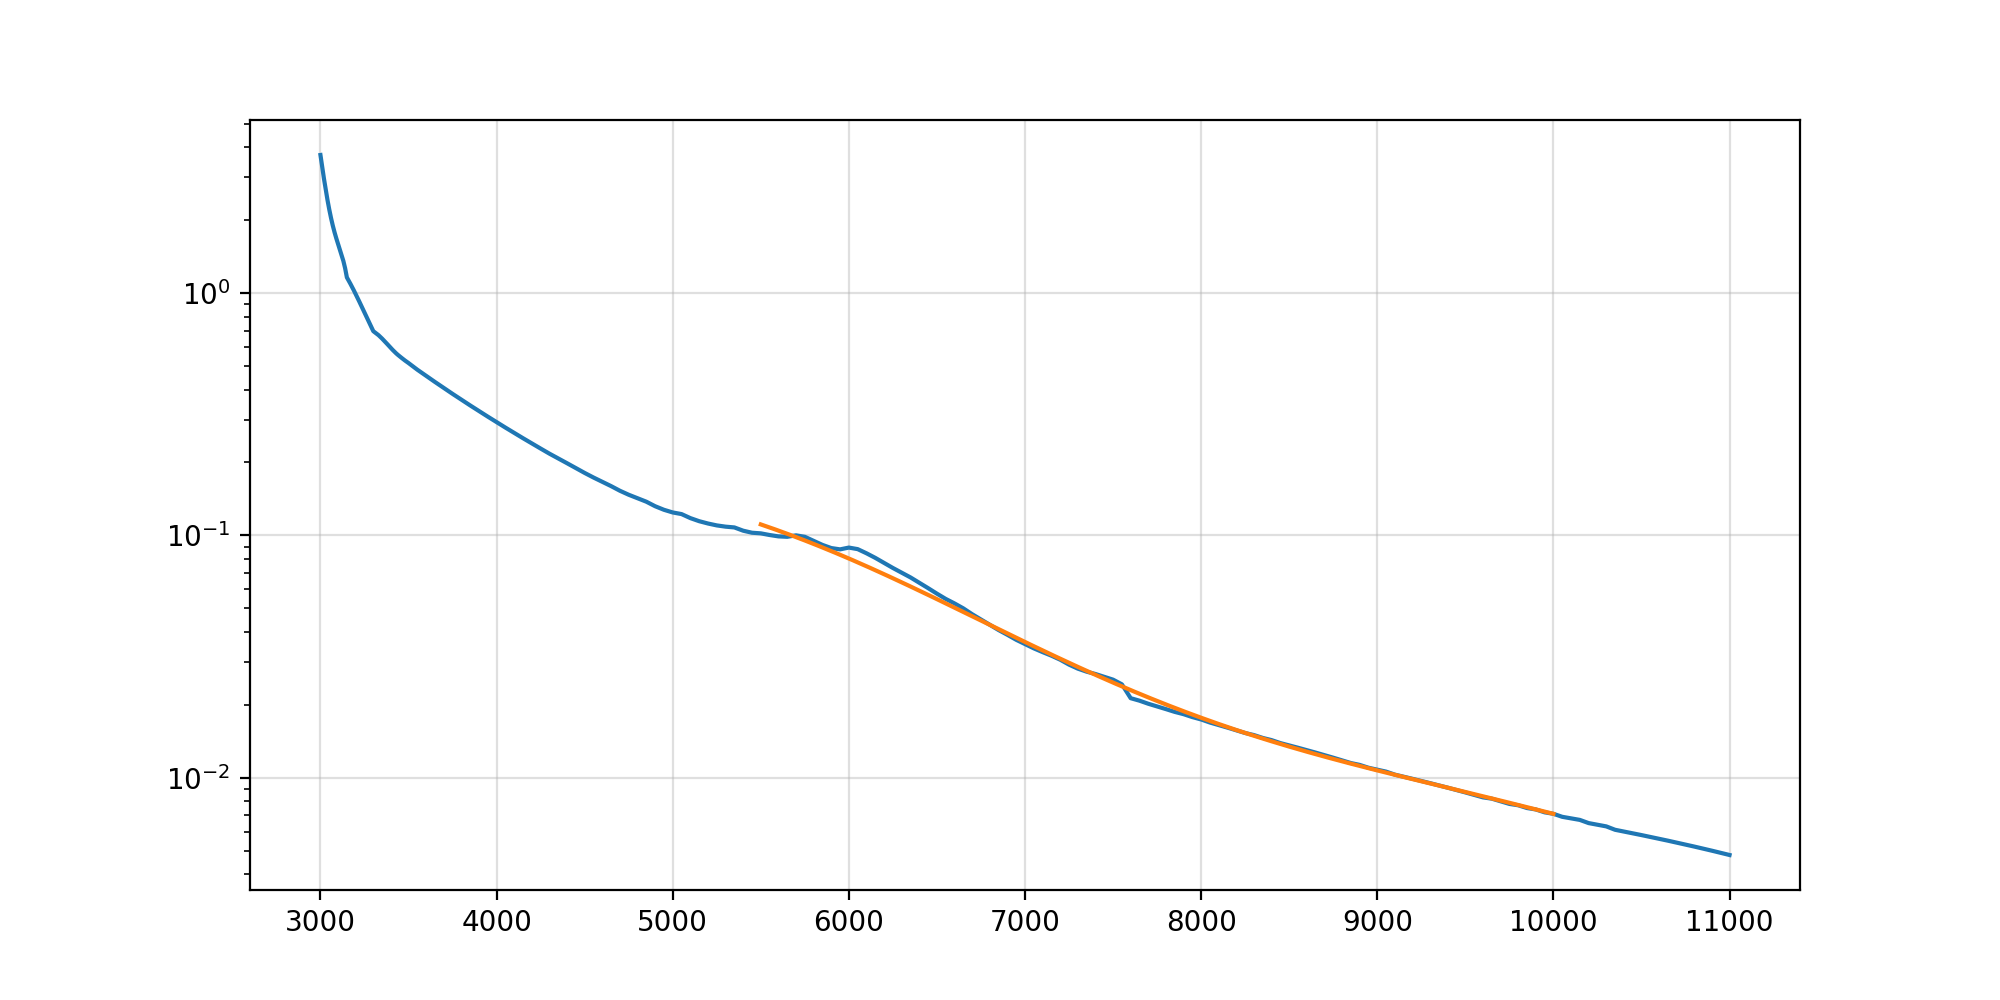

In [55]:
len(extpol)

5000